# Overview of perturbations with associated quintuplicate SEM (kcal/mol)

In [1]:
import glob
import csv
import re
import pandas as pd
import itertools
import numpy as np
from tqdm.notebook import tqdm
import csv
import matplotlib.pyplot as plt 
import seaborn as sns 
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
from collections import defaultdict

from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.warning')
from rdkit.Chem import Draw, rdFMCS

from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdqueries
from rdkit.Chem import rdDepictor, rdmolfiles
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.image as mpimg

In [2]:
quints_infos = pd.read_csv("output/quints_infos.csv", names=["set", "pertname", "pertsmarts", "num_ha", "sem"])
quints_infos

,set,pertname,pertsmarts,num_ha,sem
0,TrainingSet,mobley_1662128~mobley_7047032,[C*]C~[C*]C.[C*]Cl,2,0.156846
1,TrainingSet,mobley_7047032~mobley_1662128,[C*]C.[C*]Cl~[C*]C,2,0.156846
2,TrainingSet,mobley_7015518~mobley_303222,[C*]OC~[C*]CC,1,0.108653
3,TrainingSet,mobley_303222~mobley_7015518,[C*]CC~[C*]OC,1,0.108653
4,TrainingSet,mobley_1046331~mobley_3515580,[C*]O~[C*]O,1,0.113167
...,...,...,...,...,...
5365,TrainingSet,mobley_5326154~mobley_1019269,[C*]N(C)C1CCCCC1~[C*]CCCO,8,0.155166
5366,TrainingSet,mobley_1019269~mobley_7774695,[C*]CCCO~[C*]NC1CCCCC1,7,0.119793
5367,TrainingSet,mobley_7774695~mobley_1019269,[C*]NC1CCCCC1~[C*]CCCO,7,0.119793
5368,TrainingSet,mobley_1019269~mobley_1189457,[C*]CCCO~[C*]SC1CCCCC1,7,0.281720


In [3]:
#Draw the molecule
def get_image(mol,atomset=None):    
    hcolor = colors.to_rgb('red')
    if atomset is not None:
        #highlight the atoms set while drawing the whole molecule.
        img = MolToImage(mol, size=(600, 600),fitImage=True, highlightAtoms=atomset,highlightColor=hcolor)
    else:
        img = MolToImage(mol, size=(400, 400),fitImage=True)
    return img


def generateImages(mol,row,core,width=350,height=200,
                      fillRings=False,legend="",
                      sourceIdxProperty="SourceAtomIdx",
                      lbls=None):
    # copy the molecule and core
    mol = Chem.Mol(mol)
    core = Chem.Mol(core)

    # -------------------------------------------
    # include the atom map numbers in the substructure search in order to 
    # try to ensure a good alignment of the molecule to symmetric cores
    for at in core.GetAtoms():
        if at.GetAtomMapNum():
            at.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(200+at.GetAtomMapNum()))
            
    for lbl in row:
        if lbl=='Core':
            continue
        rg = row[lbl]
        for at in rg.GetAtoms():
            if not at.GetAtomicNum() and at.GetAtomMapNum() and \
            at.HasProp('dummyLabel') and at.GetProp('dummyLabel')==lbl:
                # attachment point. the atoms connected to this
                # should be from the molecule
                for nbr in at.GetNeighbors():
                    if nbr.HasProp(sourceIdxProperty):
                        mAt = mol.GetAtomWithIdx(nbr.GetIntProp(sourceIdxProperty))
                        if mAt.GetIsotope():
                            mAt.SetIntProp('_OrigIsotope',mAt.GetIsotope())
                        mAt.SetIsotope(200+at.GetAtomMapNum())
    # remove unmapped hs so that they don't mess up the depiction
    rhps = Chem.RemoveHsParameters()
    rhps.removeMapped = False
    tmol = Chem.RemoveHs(mol,rhps)
    rdDepictor.GenerateDepictionMatching2DStructure(tmol,core)

    oldNewAtomMap={}
    # reset the original isotope values and account for the fact that
    # removing the Hs changed atom indices
    for i,at in enumerate(tmol.GetAtoms()):
        if at.HasProp(sourceIdxProperty):
            oldNewAtomMap[at.GetIntProp(sourceIdxProperty)] = i
            if at.HasProp("_OrigIsotope"):
                at.SetIsotope(at.GetIntProp("_OrigIsotope"))
                at.ClearProp("_OrigIsotope")
            else:
                at.SetIsotope(0)
      
    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    rings = []
    # loop over R groups.
    for i,lbl in enumerate(lbls):    
        color = colors[i%len(colors)]
        try:
            rquery = row[lbl]
        # we don't know the number of R-groups, so just quit this loop if we've reached the end.
        except KeyError:
        	continue

        Chem.GetSSSR(rquery)
        rinfo = rquery.GetRingInfo()
        for at in rquery.GetAtoms():
            if at.HasProp(sourceIdxProperty):
                origIdx = oldNewAtomMap[at.GetIntProp(sourceIdxProperty)]
                highlightatoms[origIdx].append(color)
                atomrads[origIdx] = 0.4
        if fillRings:
            for aring in rinfo.AtomRings():
                tring = []
                allFound = True
                for aid in aring:
                    at = rquery.GetAtomWithIdx(aid)
                    if not at.HasProp(sourceIdxProperty):
                        allFound = False
                        break
                    tring.append(oldNewAtomMap[at.GetIntProp(sourceIdxProperty)])
                if allFound:
                    rings.append((tring,color))
        for qbnd in rquery.GetBonds():
            batom = qbnd.GetBeginAtom()
            eatom = qbnd.GetEndAtom()
            if batom.HasProp(sourceIdxProperty) and eatom.HasProp(sourceIdxProperty):
                origBnd = tmol.GetBondBetweenAtoms(oldNewAtomMap[batom.GetIntProp(sourceIdxProperty)],
                                                 oldNewAtomMap[eatom.GetIntProp(sourceIdxProperty)])
                bndIdx = origBnd.GetIdx()
                highlightbonds[bndIdx].append(color)
                widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(tmol,"",dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()

    # save to file:
    d2d.WriteDrawingText("tmp_imgs/"+legend+".png")
        
    return png

In [4]:
def plot_perts(quints_infos, precision=4):
    
    ligs_path = "./quintup_ligands/sdffiles/"

    for idx, pertinfo in quints_infos.iterrows():

        pert = pertinfo["pertname"]
        print(pert)
        
        ## get the paths to simulation folders on yoko
        with open("/home/jscheen/projects/HYDRA_LEARN/QUINTUP/COLLECTION/all_mbar_paths.txt", "r") as pathsfile:
            reader = csv.reader(pathsfile)
            for row in reader:
                if pert in row[0]:
                    print(row[0])
        
        ##


        ligA = Chem.SDMolSupplier(ligs_path+pert.split("~")[0]+".sdf")[0]
        ligB = Chem.SDMolSupplier(ligs_path+pert.split("~")[1]+".sdf")[0]

        mcs = rdFMCS.FindMCS([ligA, ligB], matchValences=False,
                                        ringMatchesRingOnly=True,
                                        completeRingsOnly=True,
                                        matchChiralTag=False)
        core = Chem.MolFromSmarts(mcs.smartsString)
        rdDepictor.Compute2DCoords(core)

        rdkit_mols = [ligA, ligB]
        # find subtructure matches with MCS per ligand, then tag matching atom indices in each ligand.
        ps = Chem.AdjustQueryParameters.NoAdjustments()
        ps.makeDummiesQueries=True
        qcore = Chem.AdjustQueryProperties(core,ps)
        #mhs = [Chem.AddHs(x,addCoords=True) for x in ms]
        mms = [x for x in rdkit_mols if x.HasSubstructMatch(core)]
        for m in mms:
            for atom in m.GetAtoms():
                atom.SetIntProp("SourceAtomIdx",atom.GetIdx())

        # do an RDKit R-group decomposition.	
        groups,_ = rdRGroupDecomposition.RGroupDecompose([qcore],mms,asSmiles=False,asRows=True)

        # call the writer function with each molecule.
        ligand_names = [pert.split("~")[0], pert.split("~")[1]]
        #for i, m in enumerate(rdkit_mols):

        generateImages(rdkit_mols[0],groups[0],qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                legend=ligand_names[0],
                                width=400,height=400)
        generateImages(rdkit_mols[1],groups[1],qcore,lbls=('R1','R2','R3','R4', 'R5', 'R6', 'R7'),
                                legend=ligand_names[1],
                                width=400,height=400)


        # now that this image is saved, load it into matplotlib for easier side-by-sde viewing.
        imgA = mpimg.imread("tmp_imgs/"+ligand_names[0]+".png")
        imgB = mpimg.imread("tmp_imgs/"+ligand_names[1]+".png")

        fig, axes = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 3, 1, 1]})
        axes[0].imshow(imgA)
        axes[1].imshow(imgB)

        # get some more pert info and annotate it.
        axes[2].annotate("    SEM:", xy=(0, 0.7), size=25)
        axes[3].annotate(round(pertinfo["sem"], 4), xy=(0, 0.7), size=25)

        axes[2].annotate("SMARTS:", xy=(0, 0.3), size=20)
        axes[3].annotate(pertinfo["pertsmarts"], xy=(0, 0.3), size=15)
        
        # get the five freenrg values that make up the SEM.
        perts_mbars = pd.read_csv("quintup_ligands/compiled_mbars_sofar.csv")
        try:
            mbar_vals = perts_mbars[perts_mbars["pert"] == pert][["freenrg_1", "freenrg_2", "freenrg_3", "freenrg_4", "freenrg_5"]].values[0]
        except IndexError:
            plt.show()
            print("__________________________________________________________________________________________________________")
            continue
        
        for i, val in enumerate(mbar_vals):
            axes[3].annotate(round(float(val), precision), xy=(0, 0.6-(i*0.05)))
        axes[2].annotate("Constituents:", xy=(0, 0.5), size=20)


        for ax in axes:
            ax.axis("off")

        plt.tight_layout()
        plt.show()
        print("__________________________________________________________________________________________________________")

# Highest 5 SEMs

mobley_1036761~mobley_4218209
./QUINTUP/30_dir_dir/finished/job_xbb/sim_3/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_1/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_5/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_4/mobley_1036761~mobley_4218209/free
./QUINTUP/30_dir_dir/finished/job_xbb/sim_2/mobley_1036761~mobley_4218209/free


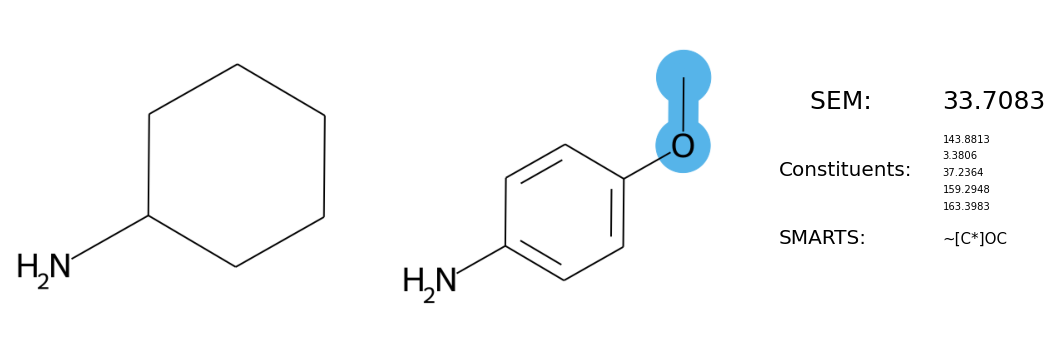

__________________________________________________________________________________________________________
mobley_4218209~mobley_1036761


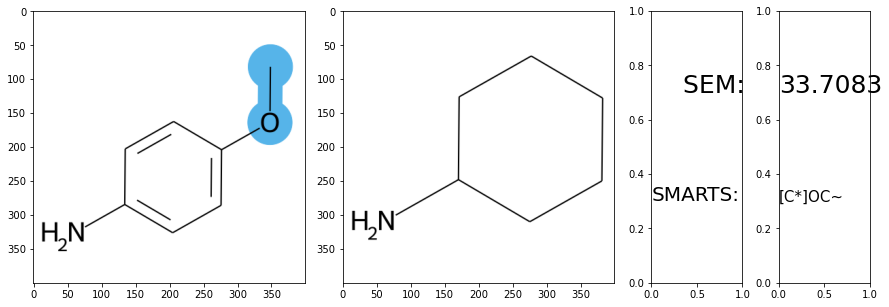

__________________________________________________________________________________________________________
mobley_1019269~mobley_4603202
./QUINTUP/25_dir_dir/round2/sim_376/mobley_1019269~mobley_4603202/free
./QUINTUP/25_dir_dir/round2/sim_378/mobley_1019269~mobley_4603202/free
./QUINTUP/25_dir_dir/round2/sim_379/mobley_1019269~mobley_4603202/free
./QUINTUP/25_dir_dir/round2/sim_380/mobley_1019269~mobley_4603202/free
./QUINTUP/25_dir_dir/round2/sim_377/mobley_1019269~mobley_4603202/free


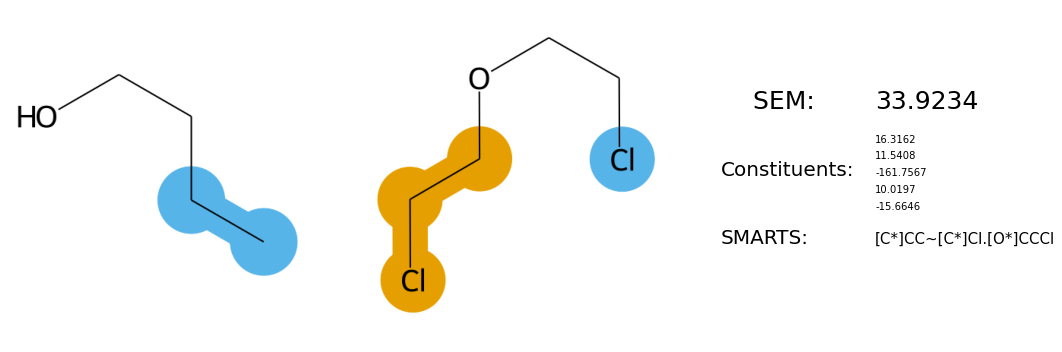

__________________________________________________________________________________________________________
mobley_4603202~mobley_1019269


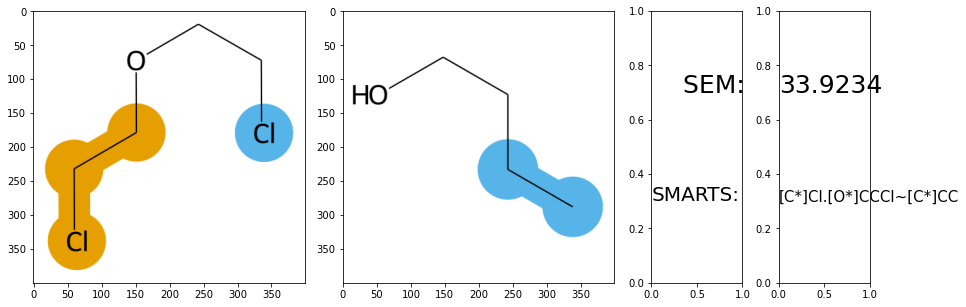

__________________________________________________________________________________________________________
mobley_2198613~mobley_627267
./QUINTUP/21_dir_dir/round1/sim_16354/mobley_2198613~mobley_627267/free
./QUINTUP/21_dir_dir/round1/sim_16353/mobley_2198613~mobley_627267/free
./QUINTUP/21_dir_dir/round1/sim_16355/mobley_2198613~mobley_627267/free
./QUINTUP/21_dir_dir/round1/sim_16351/mobley_2198613~mobley_627267/free
./QUINTUP/21_dir_dir/round1/sim_16352/mobley_2198613~mobley_627267/free


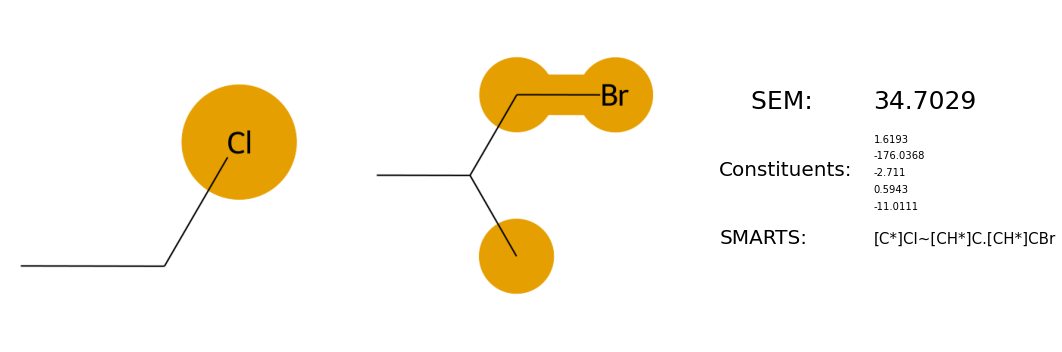

__________________________________________________________________________________________________________
mobley_627267~mobley_2198613


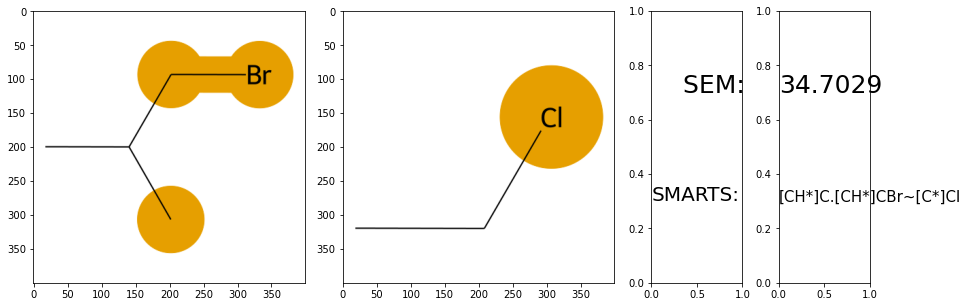

__________________________________________________________________________________________________________
mobley_2859600~mobley_1036761


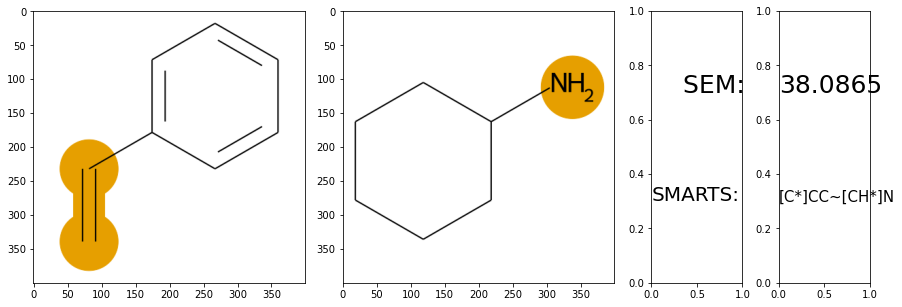

__________________________________________________________________________________________________________
mobley_1036761~mobley_2859600
./QUINTUP/30_dir_dir/finished/job_xaz/sim_14/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_13/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_12/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_15/mobley_1036761~mobley_2859600/free
./QUINTUP/30_dir_dir/finished/job_xaz/sim_11/mobley_1036761~mobley_2859600/free


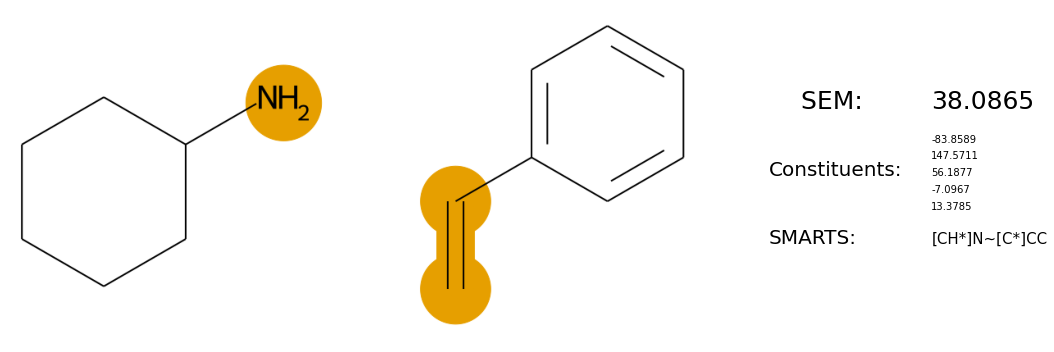

__________________________________________________________________________________________________________
mobley_1520842~mobley_8746821
./QUINTUP/30_dir_dir/finished/job_xgb/sim_18/mobley_1520842~mobley_8746821/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_20/mobley_1520842~mobley_8746821/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_17/mobley_1520842~mobley_8746821/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_19/mobley_1520842~mobley_8746821/free
./QUINTUP/30_dir_dir/finished/job_xgb/sim_16/mobley_1520842~mobley_8746821/free


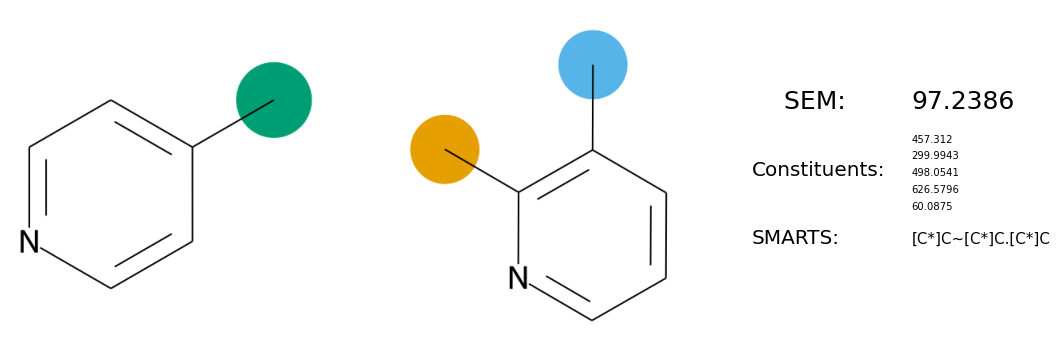

__________________________________________________________________________________________________________
mobley_8746821~mobley_1520842


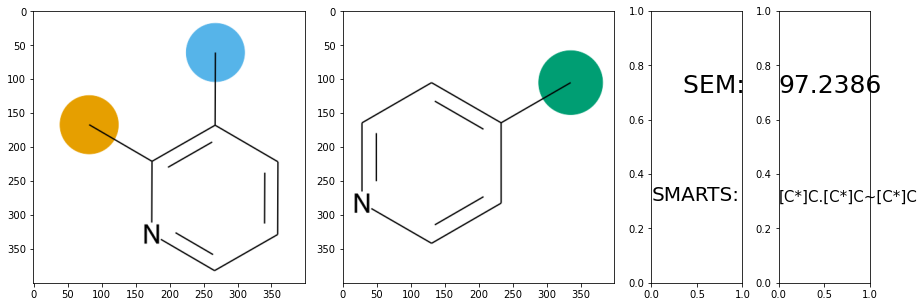

__________________________________________________________________________________________________________


In [5]:
%matplotlib inline
plot_perts(quints_infos.sort_values(by="sem").tail(10))

# SEM == 0.0:

mobley_1231151~mobley_4305650
./QUINTUP/29_dir_dir/finished/job_xbs/sim_18/mobley_1231151~mobley_4305650/free
./QUINTUP/29_dir_dir/finished/job_xbs/sim_20/mobley_1231151~mobley_4305650/free
./QUINTUP/29_dir_dir/finished/job_xbs/sim_17/mobley_1231151~mobley_4305650/free
./QUINTUP/29_dir_dir/finished/job_xbs/sim_19/mobley_1231151~mobley_4305650/free
./QUINTUP/29_dir_dir/finished/job_xbs/sim_16/mobley_1231151~mobley_4305650/free


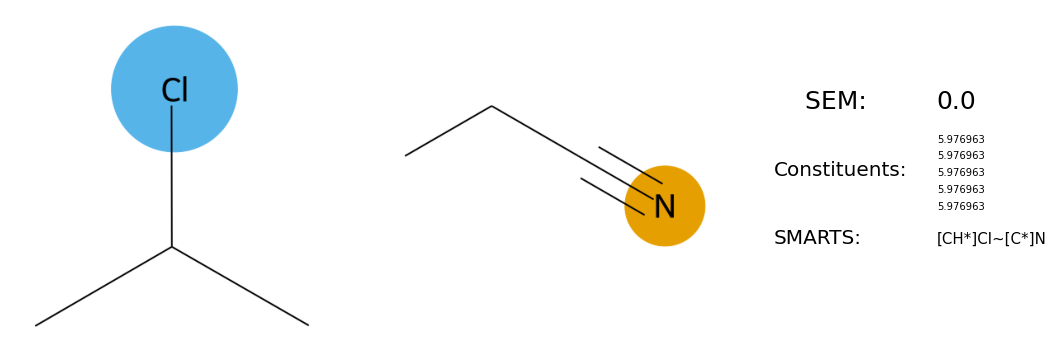

__________________________________________________________________________________________________________
mobley_4305650~mobley_1231151


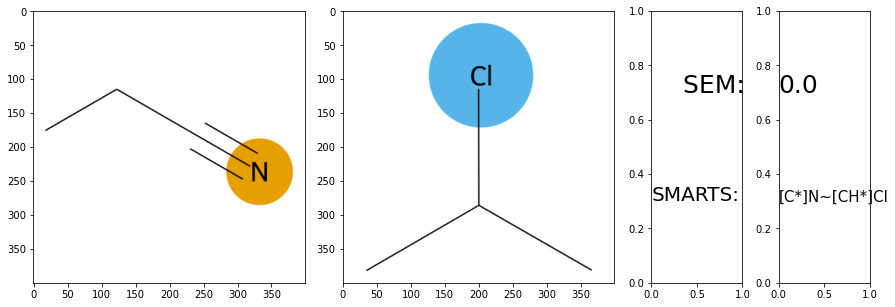

__________________________________________________________________________________________________________
mobley_9257453~mobley_7988076
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_14/mobley_9257453~mobley_7988076/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_13/mobley_9257453~mobley_7988076/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_12/mobley_9257453~mobley_7988076/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_15/mobley_9257453~mobley_7988076/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_11/mobley_9257453~mobley_7988076/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_14/mobley_9257453~mobley_7988076/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_13/mobley_9257453~mobley_7988076/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdvj/sim_12/mobley_9257453~mobley_7988076/free

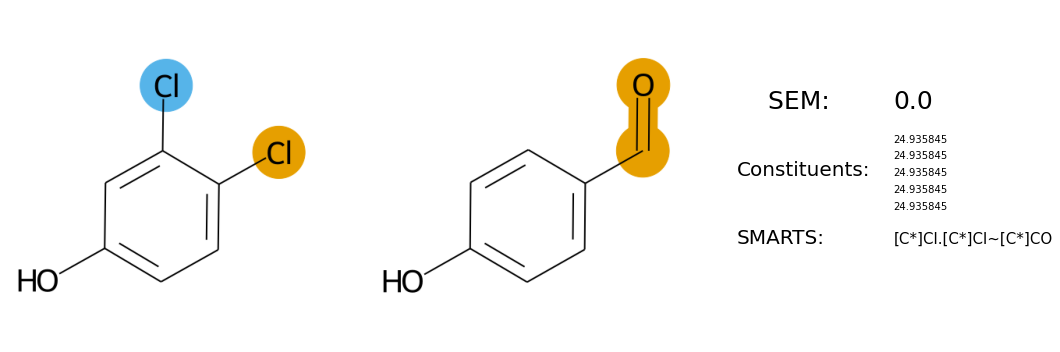

__________________________________________________________________________________________________________
mobley_7988076~mobley_9257453


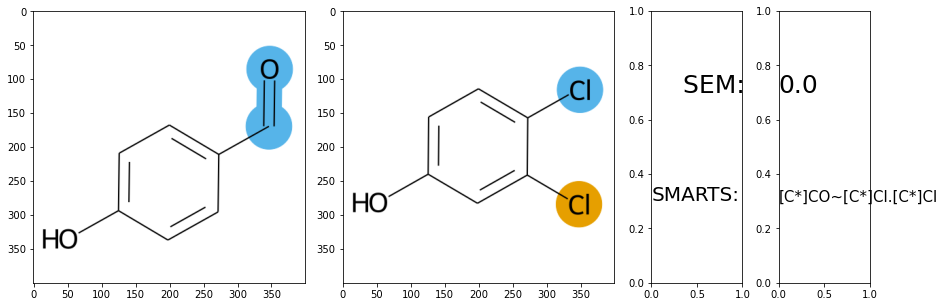

__________________________________________________________________________________________________________
mobley_9913368~mobley_4305650
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_3/mobley_9913368~mobley_4305650/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_1/mobley_9913368~mobley_4305650/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_5/mobley_9913368~mobley_4305650/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_4/mobley_9913368~mobley_4305650/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_2/mobley_9913368~mobley_4305650/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_3/mobley_9913368~mobley_4305650/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_1/mobley_9913368~mobley_4305650/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeax/sim_5/mobley_9913368~mobley_4305650/free
./MGZ_R

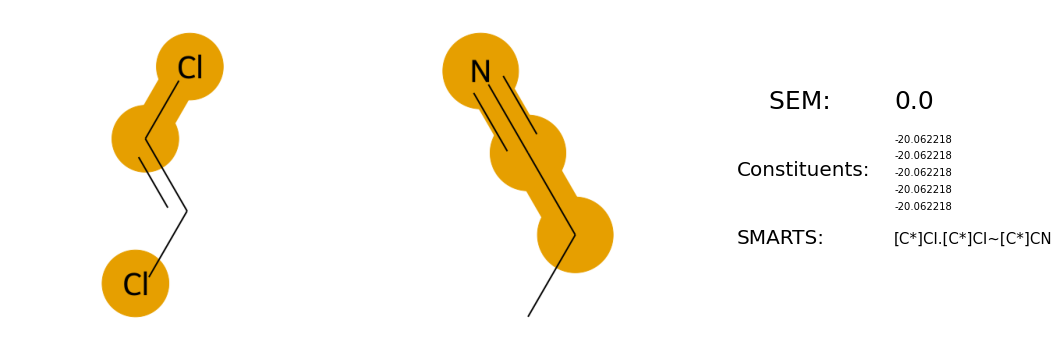

__________________________________________________________________________________________________________
mobley_4305650~mobley_9913368


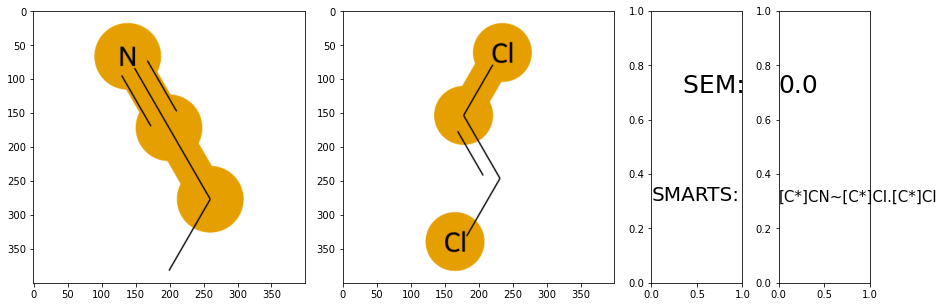

__________________________________________________________________________________________________________
mobley_1178614~mobley_7066554
./QUINTUP/29_dir_dir/finished/job_xbh/sim_7/mobley_1178614~mobley_7066554/free
./QUINTUP/29_dir_dir/finished/job_xbh/sim_9/mobley_1178614~mobley_7066554/free
./QUINTUP/29_dir_dir/finished/job_xbh/sim_8/mobley_1178614~mobley_7066554/free
./QUINTUP/29_dir_dir/finished/job_xbh/sim_6/mobley_1178614~mobley_7066554/free
./QUINTUP/29_dir_dir/finished/job_xbh/sim_10/mobley_1178614~mobley_7066554/free


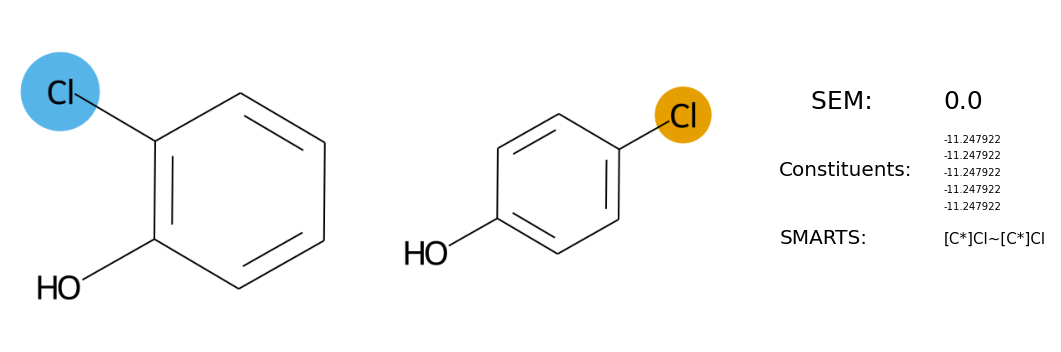

__________________________________________________________________________________________________________
mobley_7066554~mobley_1178614


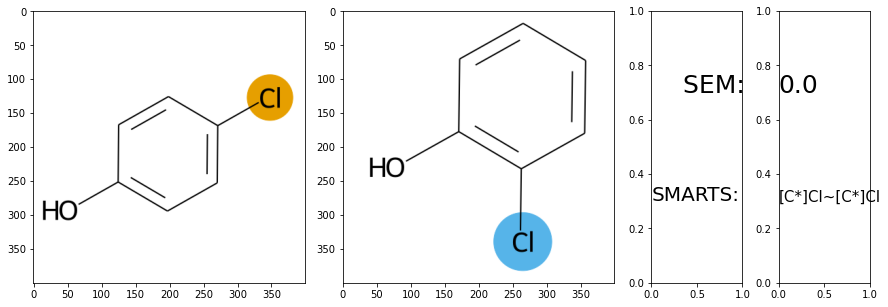

__________________________________________________________________________________________________________
mobley_1977493~mobley_2198613
./QUINTUP/29_dir_dir/finished/job_xil/sim_7/mobley_1977493~mobley_2198613/free
./QUINTUP/29_dir_dir/finished/job_xil/sim_9/mobley_1977493~mobley_2198613/free
./QUINTUP/29_dir_dir/finished/job_xil/sim_8/mobley_1977493~mobley_2198613/free
./QUINTUP/29_dir_dir/finished/job_xil/sim_6/mobley_1977493~mobley_2198613/free
./QUINTUP/29_dir_dir/finished/job_xil/sim_10/mobley_1977493~mobley_2198613/free


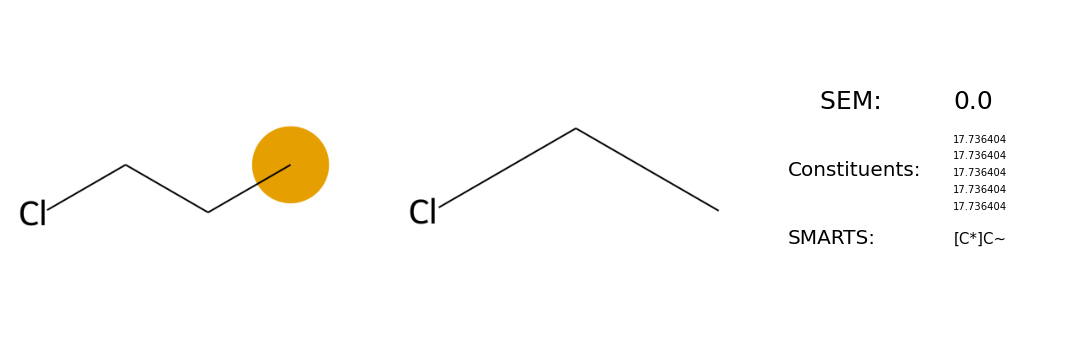

__________________________________________________________________________________________________________
mobley_2198613~mobley_1977493


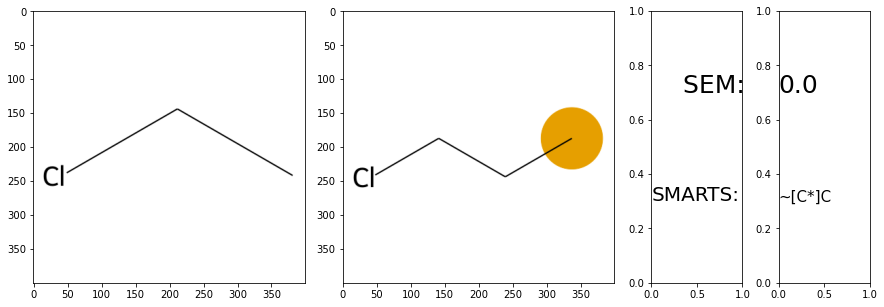

__________________________________________________________________________________________________________


In [6]:
plot_perts(quints_infos[quints_infos["sem"] == 0.0].tail(10), precision=6)

# Lowest realistic SEMs:

mobley_1563176~mobley_2802855
./QUINTUP/29_dir_dir/finished/job_xcq/sim_14/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_13/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_12/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_15/mobley_1563176~mobley_2802855/free
./QUINTUP/29_dir_dir/finished/job_xcq/sim_11/mobley_1563176~mobley_2802855/free


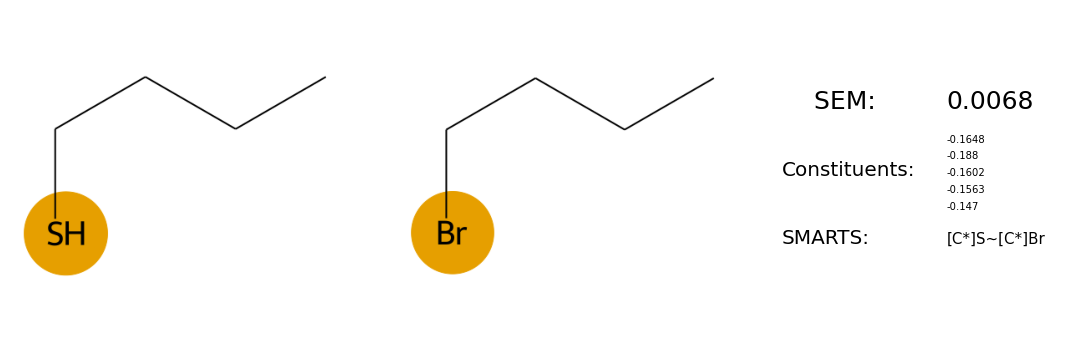

__________________________________________________________________________________________________________
mobley_2802855~mobley_1563176


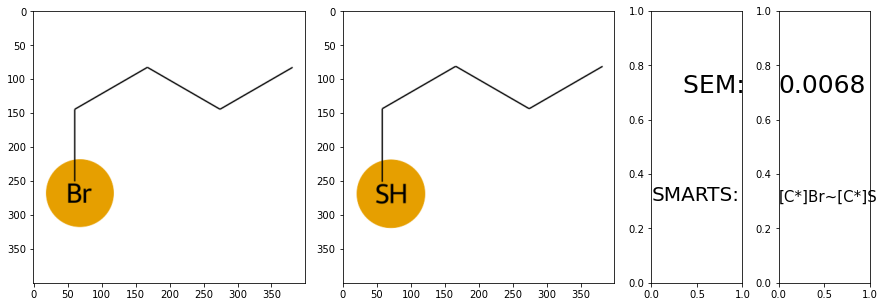

__________________________________________________________________________________________________________
mobley_1755375~mobley_5571660
./QUINTUP/29_dir_dir/finished/job_xej/sim_3/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_1/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_5/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_4/mobley_1755375~mobley_5571660/free
./QUINTUP/29_dir_dir/finished/job_xej/sim_2/mobley_1755375~mobley_5571660/free


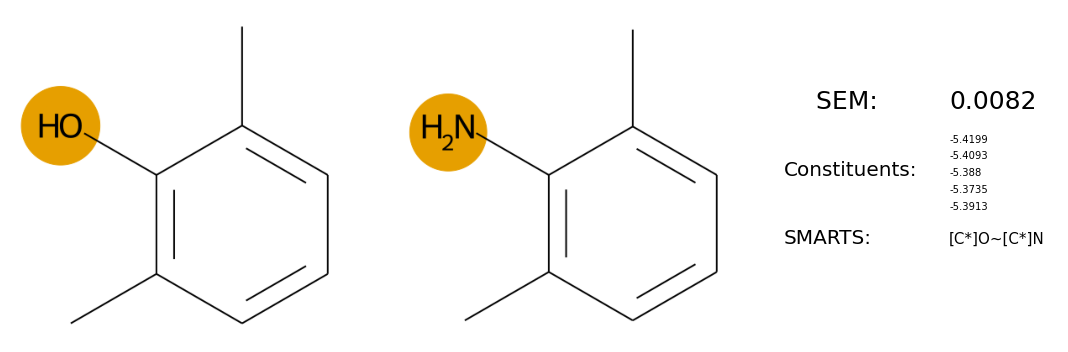

__________________________________________________________________________________________________________
mobley_5571660~mobley_1755375


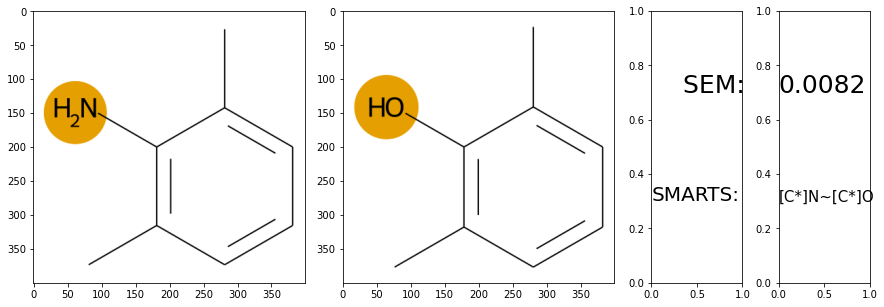

__________________________________________________________________________________________________________
mobley_186894~mobley_7708038
./QUINTUP/29_dir_dir/finished/job_xft/sim_3/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_1/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_5/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_4/mobley_186894~mobley_7708038/free
./QUINTUP/29_dir_dir/finished/job_xft/sim_2/mobley_186894~mobley_7708038/free


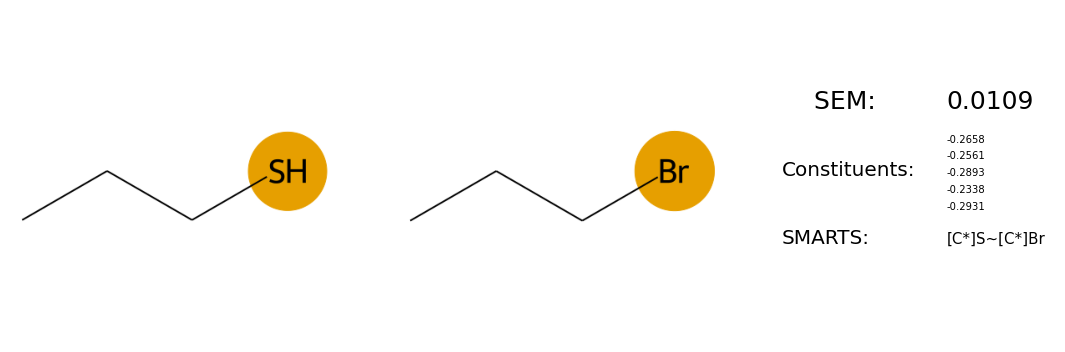

__________________________________________________________________________________________________________
mobley_7708038~mobley_186894


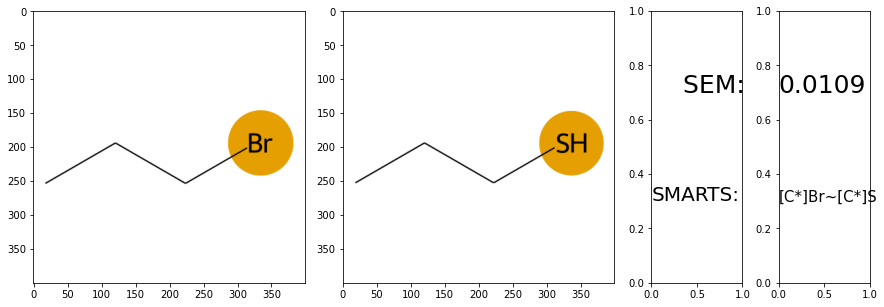

__________________________________________________________________________________________________________
mobley_9733743~mobley_2422586
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_18/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_20/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_17/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_19/mobley_9733743~mobley_2422586/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_16/mobley_9733743~mobley_2422586/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_18/mobley_9733743~mobley_2422586/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_20/mobley_9733743~mobley_2422586/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyn/sim_17/mobley_9733743~mobley_2422586/free

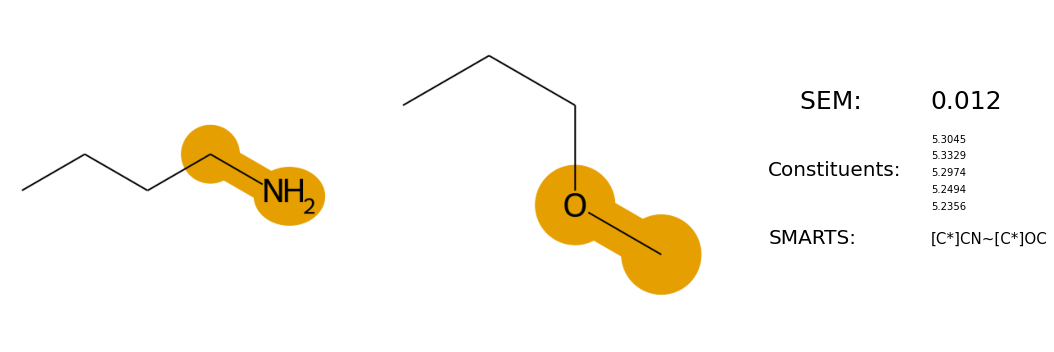

__________________________________________________________________________________________________________
mobley_2422586~mobley_9733743


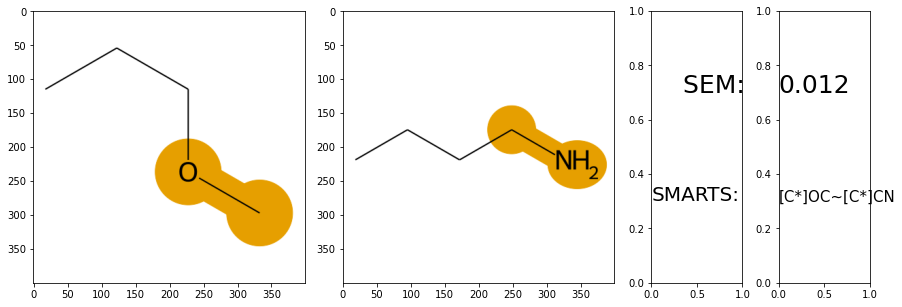

__________________________________________________________________________________________________________
mobley_1017962~mobley_7977115
./QUINTUP/24_dir_dir/round2/sim_194/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_191/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_192/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_193/mobley_1017962~mobley_7977115/free
./QUINTUP/24_dir_dir/round2/sim_195/mobley_1017962~mobley_7977115/free


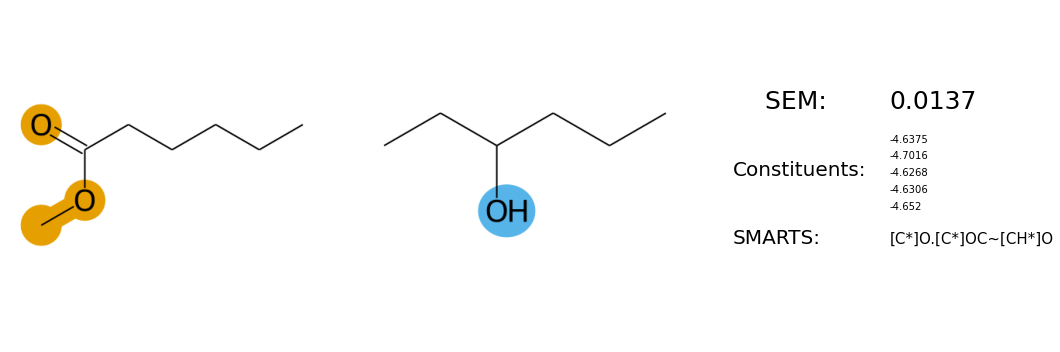

__________________________________________________________________________________________________________
mobley_7977115~mobley_1017962


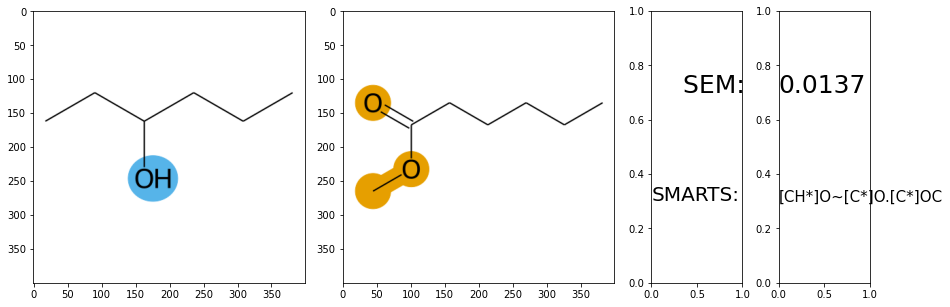

__________________________________________________________________________________________________________


In [7]:
plot_perts(quints_infos[(quints_infos["sem"] > 0.001)].sort_values(by="sem").head(10))

# Randomly picked realistic SEMs:

mobley_3053621~mobley_9478823


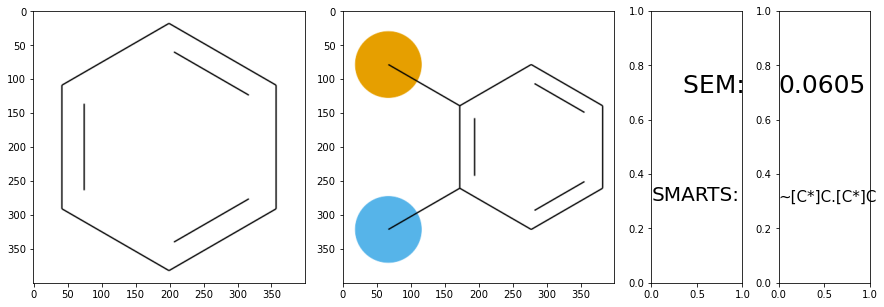

__________________________________________________________________________________________________________
mobley_9838013~mobley_7769613
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeaa/sim_18/mobley_9838013~mobley_7769613/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeaa/sim_20/mobley_9838013~mobley_7769613/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeaa/sim_17/mobley_9838013~mobley_7769613/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeaa/sim_19/mobley_9838013~mobley_7769613/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeaa/sim_16/mobley_9838013~mobley_7769613/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeaa/sim_18/mobley_9838013~mobley_7769613/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeaa/sim_20/mobley_9838013~mobley_7769613/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeaa/sim_17/mobley_9838013~mobley_7769613/free

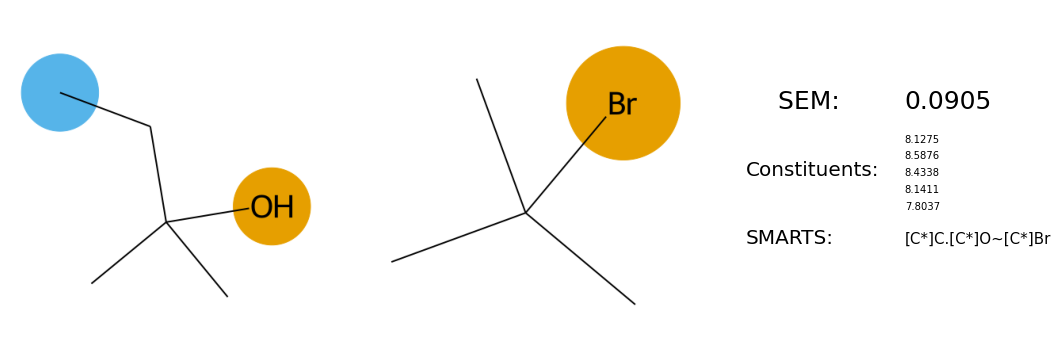

__________________________________________________________________________________________________________
mobley_2923700~mobley_1858644


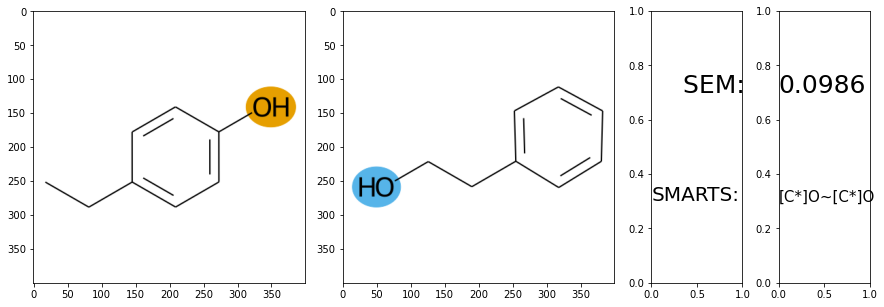

__________________________________________________________________________________________________________
mobley_1592519~mobley_1017962
./QUINTUP/29_dir_dir/finished/job_xcz/sim_14/mobley_1592519~mobley_1017962/free
./QUINTUP/29_dir_dir/finished/job_xcz/sim_13/mobley_1592519~mobley_1017962/free
./QUINTUP/29_dir_dir/finished/job_xcz/sim_12/mobley_1592519~mobley_1017962/free
./QUINTUP/29_dir_dir/finished/job_xcz/sim_15/mobley_1592519~mobley_1017962/free
./QUINTUP/29_dir_dir/finished/job_xcz/sim_11/mobley_1592519~mobley_1017962/free


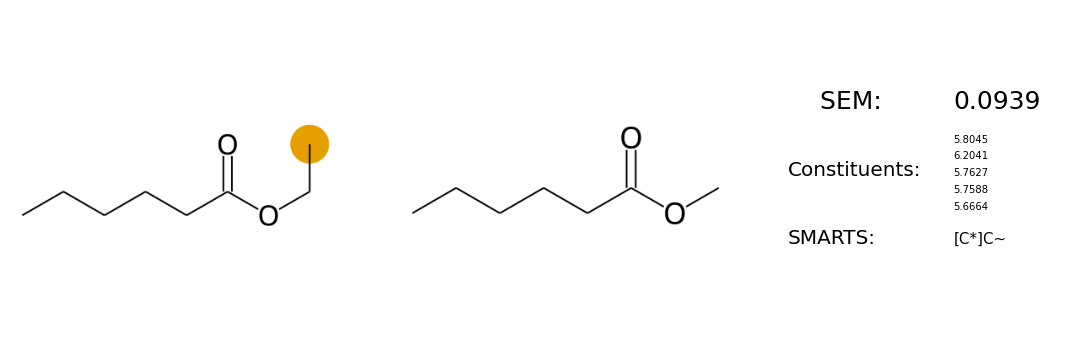

__________________________________________________________________________________________________________
mobley_4561957~mobley_1017962


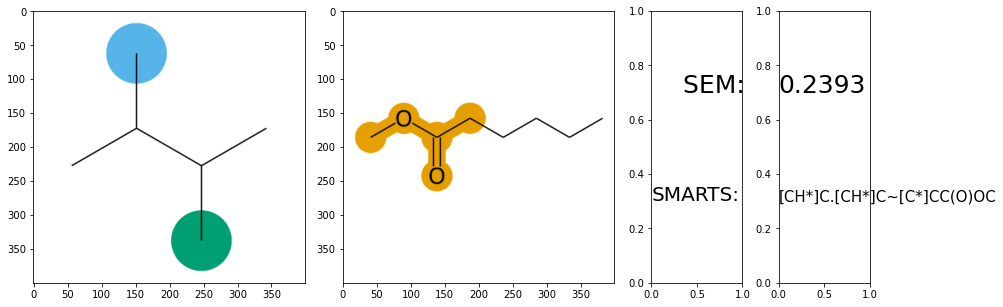

__________________________________________________________________________________________________________
mobley_6190089~mobley_2198613


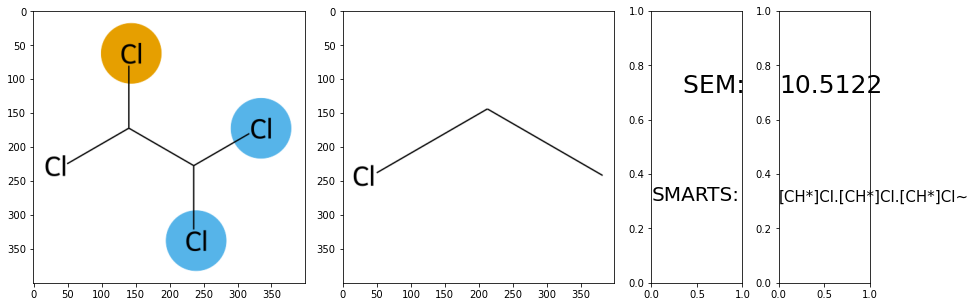

__________________________________________________________________________________________________________
mobley_9733743~mobley_5286200
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyq/sim_14/mobley_9733743~mobley_5286200/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyq/sim_13/mobley_9733743~mobley_5286200/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyq/sim_12/mobley_9733743~mobley_5286200/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyq/sim_15/mobley_9733743~mobley_5286200/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdyq/sim_11/mobley_9733743~mobley_5286200/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyq/sim_14/mobley_9733743~mobley_5286200/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyq/sim_13/mobley_9733743~mobley_5286200/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdyq/sim_12/mobley_9733743~mobley_5286200/free

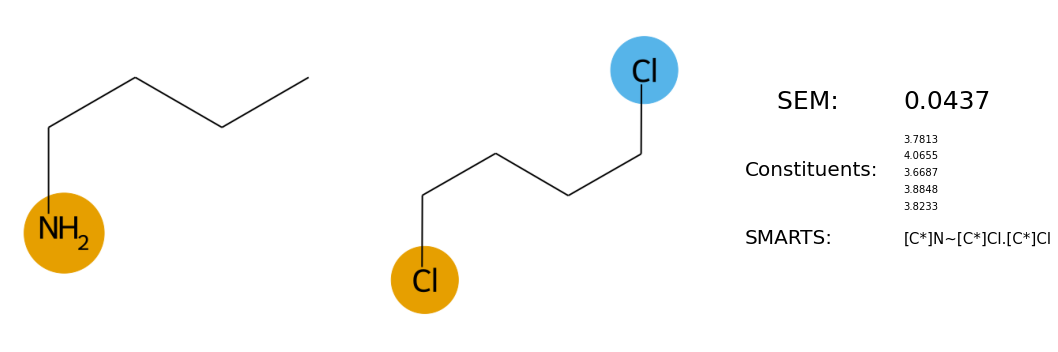

__________________________________________________________________________________________________________
mobley_1328465~mobley_1893815
./QUINTUP/29_dir_dir/finished/job_xbz/sim_18/mobley_1328465~mobley_1893815/free
./QUINTUP/29_dir_dir/finished/job_xbz/sim_20/mobley_1328465~mobley_1893815/free
./QUINTUP/29_dir_dir/finished/job_xbz/sim_17/mobley_1328465~mobley_1893815/free
./QUINTUP/29_dir_dir/finished/job_xbz/sim_19/mobley_1328465~mobley_1893815/free
./QUINTUP/29_dir_dir/finished/job_xbz/sim_16/mobley_1328465~mobley_1893815/free


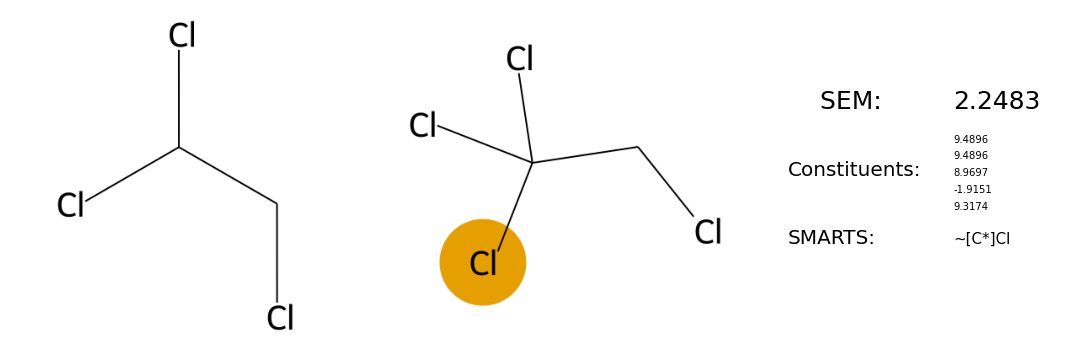

__________________________________________________________________________________________________________
mobley_1977493~mobley_7099614
./QUINTUP/31_dir_dir/transform_0/finished/sim_128/mobley_1977493~mobley_7099614/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_127/mobley_1977493~mobley_7099614/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_126/mobley_1977493~mobley_7099614/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_129/mobley_1977493~mobley_7099614/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_130/mobley_1977493~mobley_7099614/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_128/mobley_1977493~mobley_7099614/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_127/mobley_1977493~mobley_7099614/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_126/mobley_1977493~mobley_7099614/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_129/mobley_1977493~mobley_7099614/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_130/mobley_1977493~mobley_7099614/free


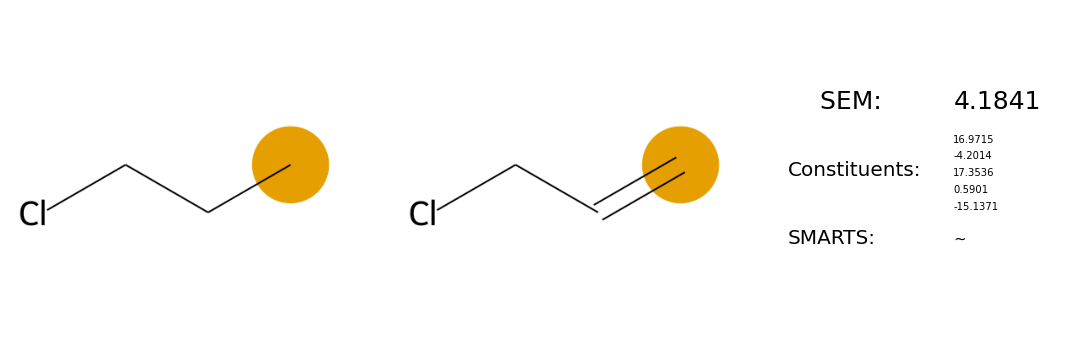

__________________________________________________________________________________________________________
mobley_4759887~mobley_929676


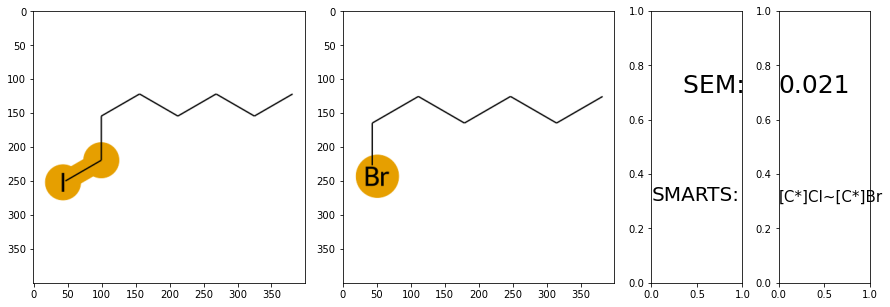

__________________________________________________________________________________________________________
mobley_1615431~mobley_9626434


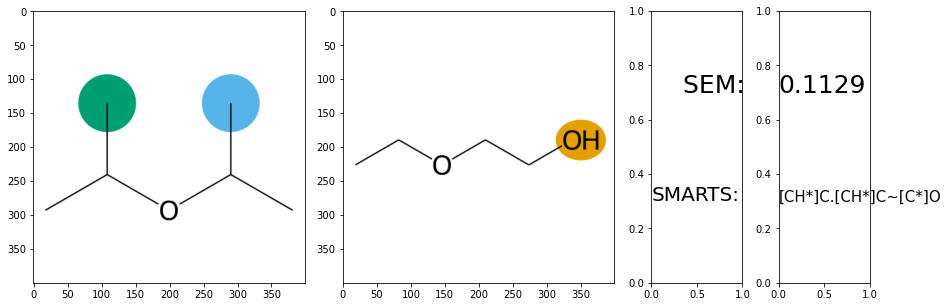

__________________________________________________________________________________________________________
mobley_1019269~mobley_1650157
./QUINTUP/30_dir_dir/finished/job_xaf/sim_18/mobley_1019269~mobley_1650157/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_20/mobley_1019269~mobley_1650157/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_17/mobley_1019269~mobley_1650157/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_19/mobley_1019269~mobley_1650157/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_16/mobley_1019269~mobley_1650157/free


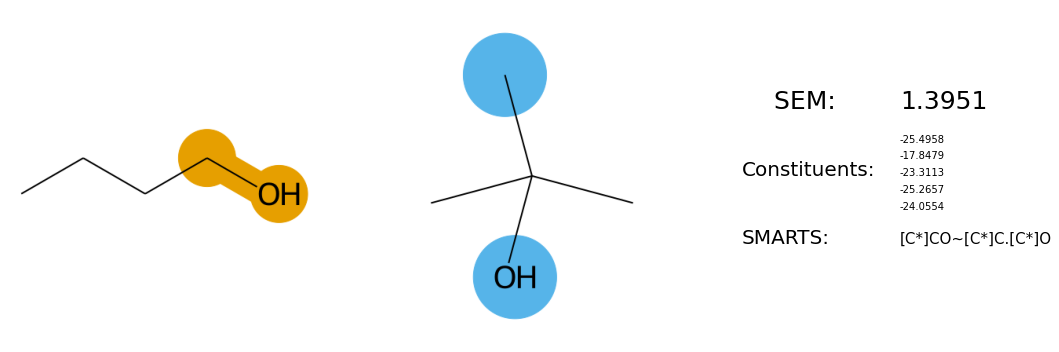

__________________________________________________________________________________________________________
mobley_5346580~mobley_6497672
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_3/mobley_5346580~mobley_6497672/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_0/GPU_population_1/mobley_5346580~mobley_6497672/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_2/mobley_5346580~mobley_6497672/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_0/mobley_5346580~mobley_6497672/free
./QUINTUP/20_dir_dir/quintup_transform_3/job_1/GPU_population_3/mobley_5346580~mobley_6497672/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_3/mobley_5346580~mobley_6497672/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_0/GPU_population_1/mobley_5346580~mobley_6497672/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/job_1/GPU_population_2/mobley_5346580~mobley_6497672/free
./QUINTUP/23_dir_dir/round2/quintup_transform_3/jo

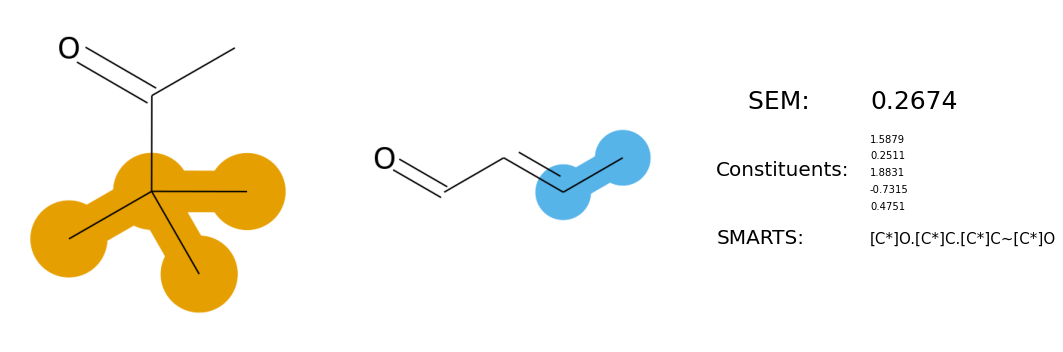

__________________________________________________________________________________________________________
mobley_9794857~mobley_3259411
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzh/sim_7/mobley_9794857~mobley_3259411/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzh/sim_9/mobley_9794857~mobley_3259411/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzh/sim_8/mobley_9794857~mobley_3259411/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzh/sim_6/mobley_9794857~mobley_3259411/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdzh/sim_10/mobley_9794857~mobley_3259411/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzh/sim_7/mobley_9794857~mobley_3259411/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzh/sim_9/mobley_9794857~mobley_3259411/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdzh/sim_8/mobley_9794857~mobley_3259411/free
./MGZ_

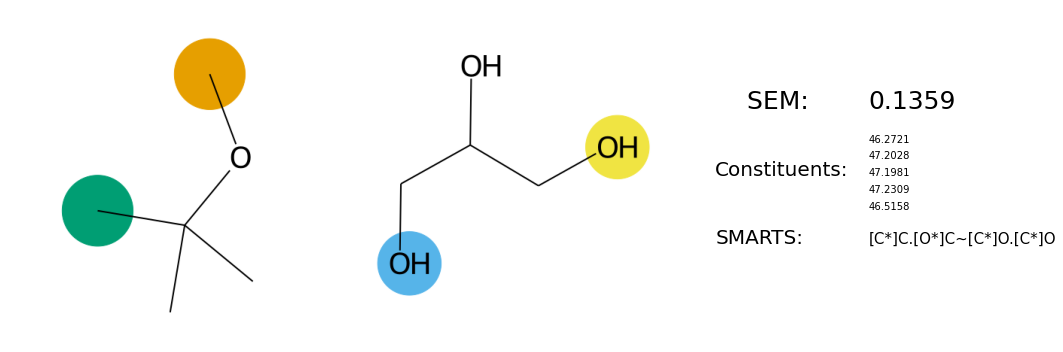

__________________________________________________________________________________________________________
mobley_8337977~mobley_1899443


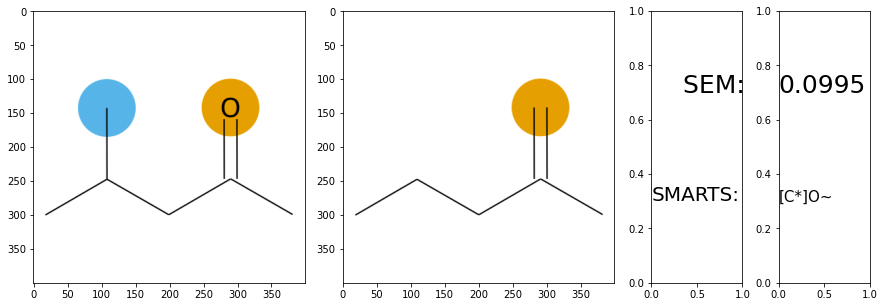

__________________________________________________________________________________________________________
mobley_9617923~mobley_9897248
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxi/sim_17/mobley_9617923~mobley_9897248/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxi/mobley_9617923~mobley_9897248/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzdxi/sim_16/mobley_9617923~mobley_9897248/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxi/sim_17/mobley_9617923~mobley_9897248/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxi/mobley_9617923~mobley_9897248/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzdxi/sim_16/mobley_9617923~mobley_9897248/free


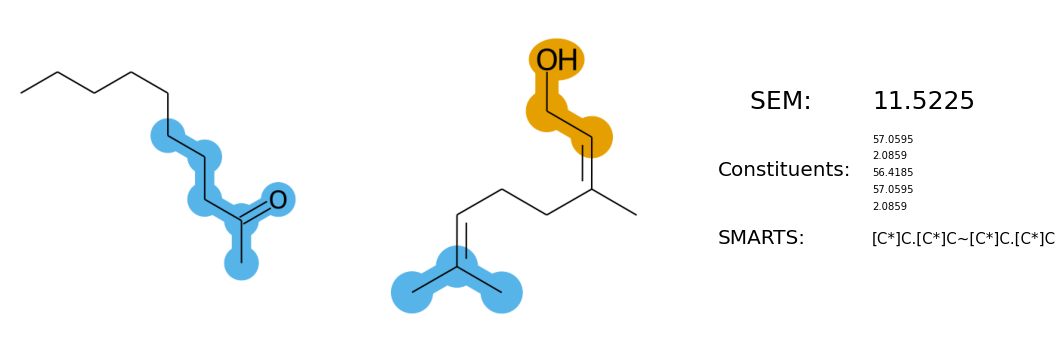

__________________________________________________________________________________________________________
mobley_7578802~mobley_9434451


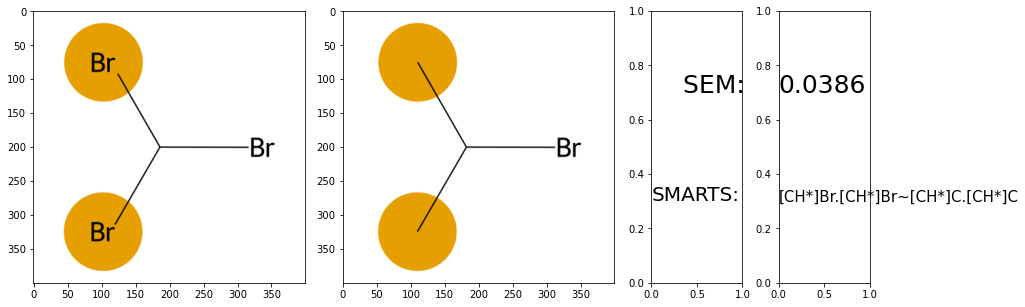

__________________________________________________________________________________________________________
mobley_3982371~mobley_1075836


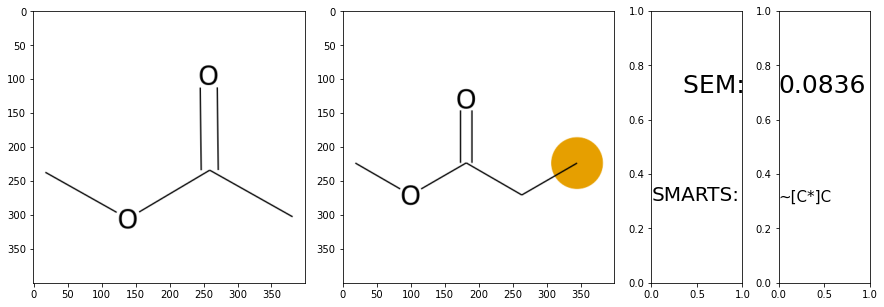

__________________________________________________________________________________________________________
mobley_1019269~mobley_3414356
./QUINTUP/30_dir_dir/finished/job_xal/sim_14/mobley_1019269~mobley_3414356/free
./QUINTUP/30_dir_dir/finished/job_xal/sim_13/mobley_1019269~mobley_3414356/free
./QUINTUP/30_dir_dir/finished/job_xal/sim_12/mobley_1019269~mobley_3414356/free
./QUINTUP/30_dir_dir/finished/job_xal/sim_15/mobley_1019269~mobley_3414356/free
./QUINTUP/30_dir_dir/finished/job_xal/sim_11/mobley_1019269~mobley_3414356/free


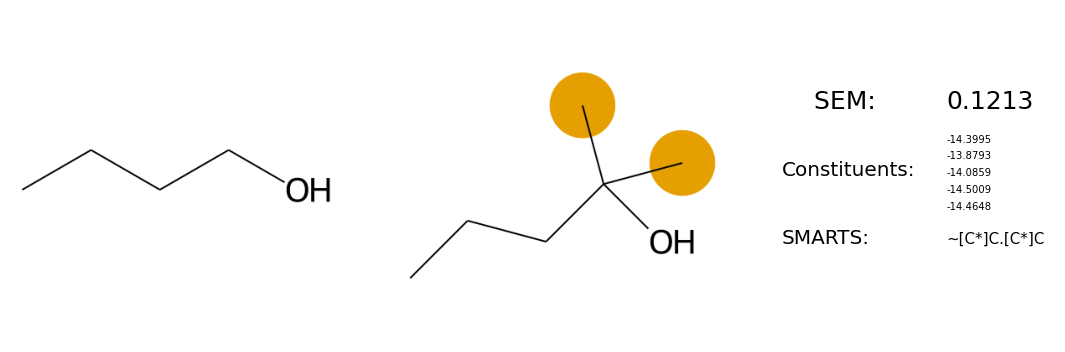

__________________________________________________________________________________________________________
mobley_1019269~mobley_9974966
./QUINTUP/25_dir_dir/round2/sim_524/mobley_1019269~mobley_9974966/free
./QUINTUP/25_dir_dir/round2/sim_523/mobley_1019269~mobley_9974966/free
./QUINTUP/25_dir_dir/round2/sim_521/mobley_1019269~mobley_9974966/free
./QUINTUP/25_dir_dir/round2/sim_522/mobley_1019269~mobley_9974966/free
./QUINTUP/25_dir_dir/round2/sim_525/mobley_1019269~mobley_9974966/free


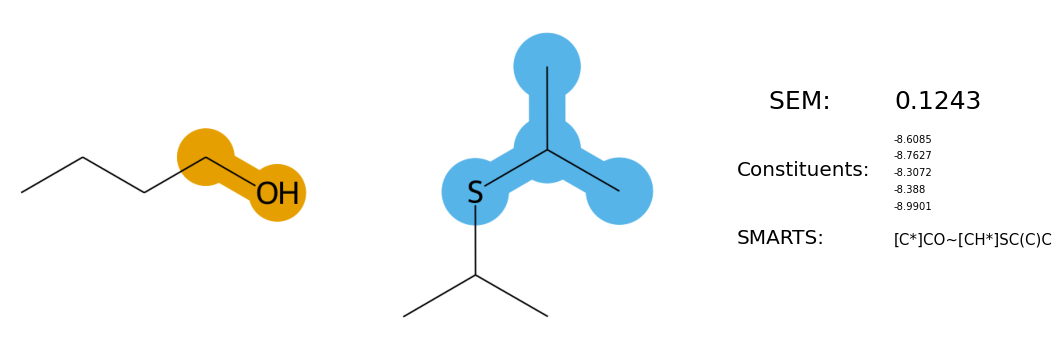

__________________________________________________________________________________________________________
mobley_9197172~mobley_1017962


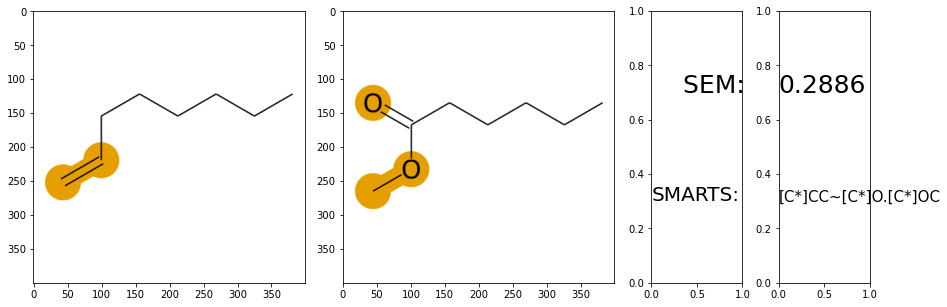

__________________________________________________________________________________________________________
mobley_6896128~mobley_5079234


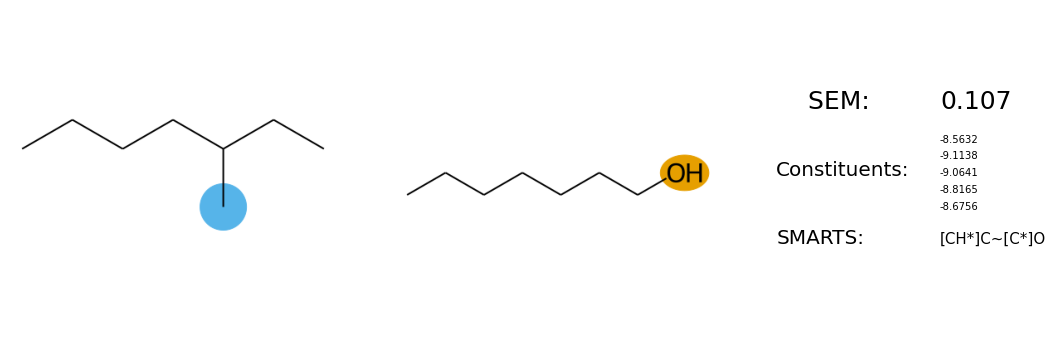

__________________________________________________________________________________________________________
mobley_1662128~mobley_1199854
./QUINTUP/29_dir_dir/finished/job_xdd/sim_18/mobley_1662128~mobley_1199854/free
./QUINTUP/29_dir_dir/finished/job_xdd/sim_20/mobley_1662128~mobley_1199854/free
./QUINTUP/29_dir_dir/finished/job_xdd/sim_17/mobley_1662128~mobley_1199854/free
./QUINTUP/29_dir_dir/finished/job_xdd/sim_19/mobley_1662128~mobley_1199854/free
./QUINTUP/29_dir_dir/finished/job_xdd/sim_16/mobley_1662128~mobley_1199854/free


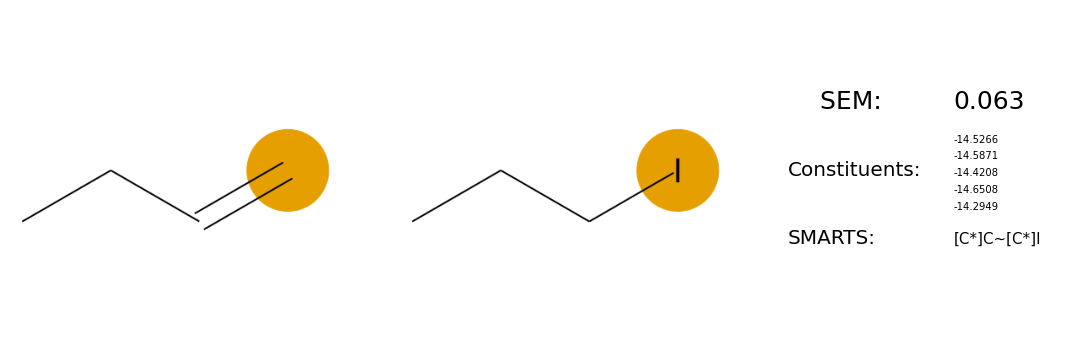

__________________________________________________________________________________________________________
mobley_1903702~mobley_3269565
./QUINTUP/29_dir_dir/finished/job_xhj/sim_18/mobley_1903702~mobley_3269565/free
./QUINTUP/29_dir_dir/finished/job_xhj/sim_20/mobley_1903702~mobley_3269565/free
./QUINTUP/29_dir_dir/finished/job_xhj/sim_17/mobley_1903702~mobley_3269565/free
./QUINTUP/29_dir_dir/finished/job_xhj/sim_19/mobley_1903702~mobley_3269565/free
./QUINTUP/29_dir_dir/finished/job_xhj/sim_16/mobley_1903702~mobley_3269565/free


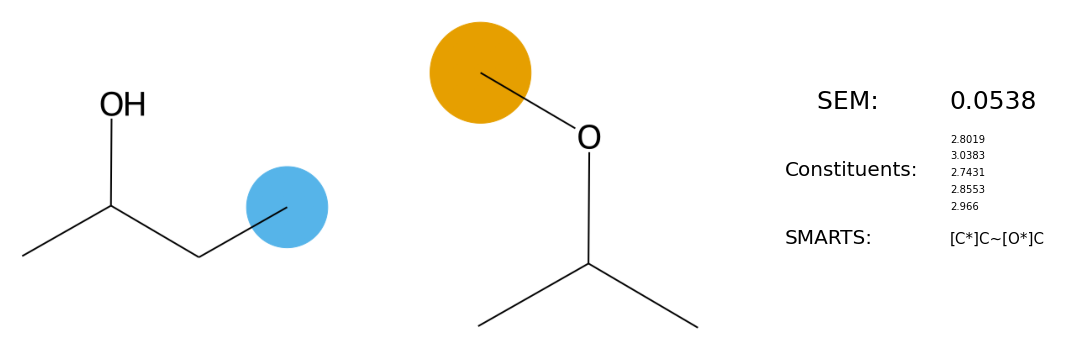

__________________________________________________________________________________________________________
mobley_4375719~mobley_9617923


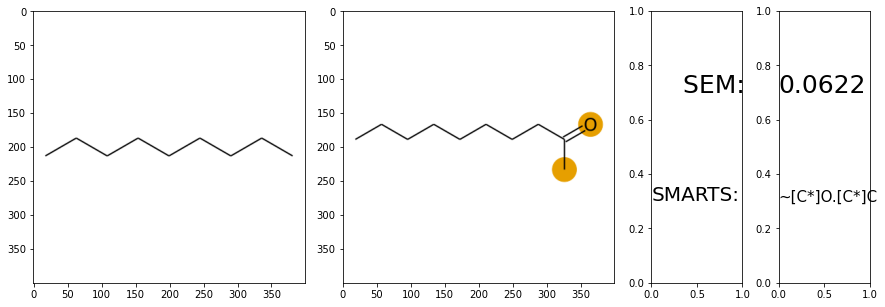

__________________________________________________________________________________________________________
mobley_1019269~mobley_8191186
./QUINTUP/25_dir_dir/round2/sim_482/mobley_1019269~mobley_8191186/free
./QUINTUP/25_dir_dir/round2/sim_481/mobley_1019269~mobley_8191186/free
./QUINTUP/25_dir_dir/round2/sim_483/mobley_1019269~mobley_8191186/free
./QUINTUP/25_dir_dir/round2/sim_485/mobley_1019269~mobley_8191186/free
./QUINTUP/25_dir_dir/round2/sim_484/mobley_1019269~mobley_8191186/free


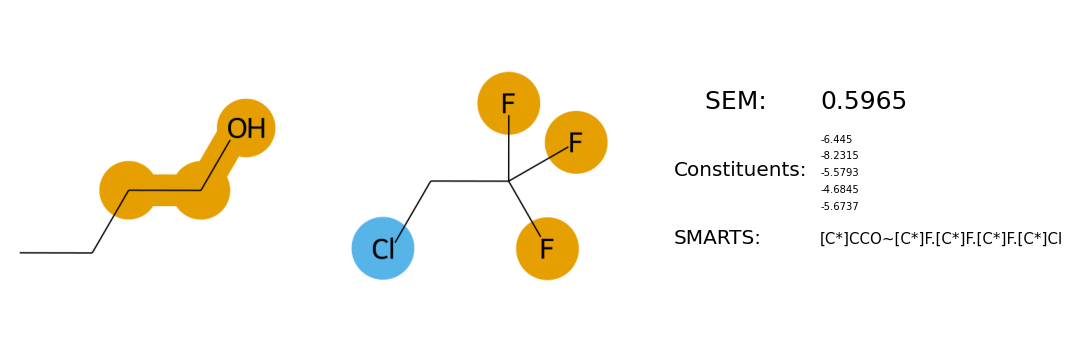

__________________________________________________________________________________________________________
mobley_2008055~mobley_1636752


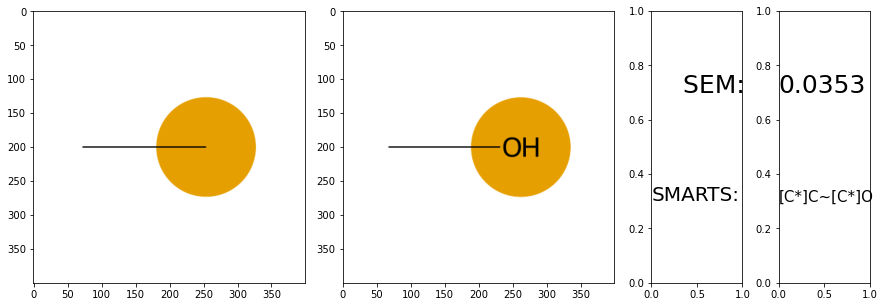

__________________________________________________________________________________________________________
mobley_1899443~mobley_2143011
./QUINTUP/29_dir_dir/finished/job_xgx/sim_3/mobley_1899443~mobley_2143011/free
./QUINTUP/29_dir_dir/finished/job_xgx/sim_1/mobley_1899443~mobley_2143011/free
./QUINTUP/29_dir_dir/finished/job_xgx/sim_5/mobley_1899443~mobley_2143011/free
./QUINTUP/29_dir_dir/finished/job_xgx/sim_4/mobley_1899443~mobley_2143011/free
./QUINTUP/29_dir_dir/finished/job_xgx/sim_2/mobley_1899443~mobley_2143011/free


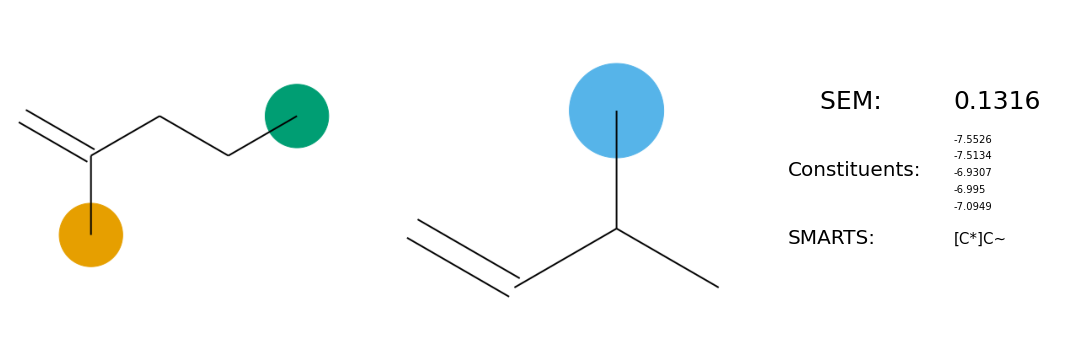

__________________________________________________________________________________________________________
mobley_1803862~mobley_2143011
./QUINTUP/31_dir_dir/transform_0/finished/sim_55/mobley_1803862~mobley_2143011/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_53/mobley_1803862~mobley_2143011/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_54/mobley_1803862~mobley_2143011/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_51/mobley_1803862~mobley_2143011/free
./QUINTUP/31_dir_dir/transform_0/finished/sim_52/mobley_1803862~mobley_2143011/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_55/mobley_1803862~mobley_2143011/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_53/mobley_1803862~mobley_2143011/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_54/mobley_1803862~mobley_2143011/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_51/mobley_1803862~mobley_2143011/free
./QUINTUP/32_dir_dir/transform_0/finished/sim_52/mobley_1803862~mobley_2143011/free


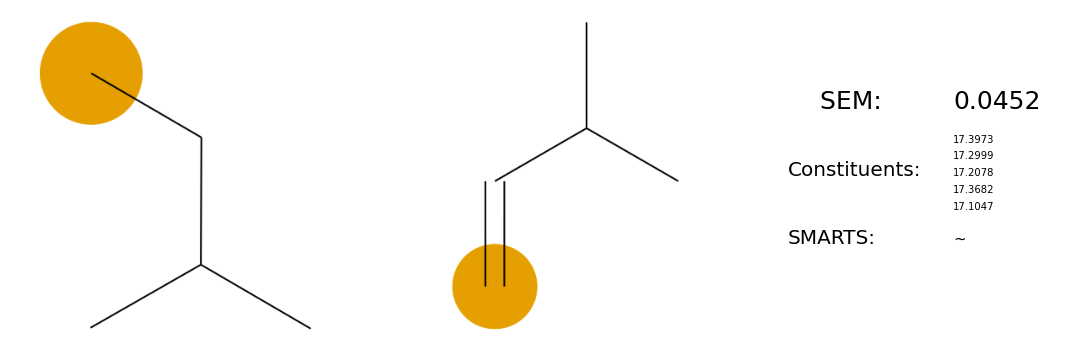

__________________________________________________________________________________________________________
mobley_8765203~mobley_1674094


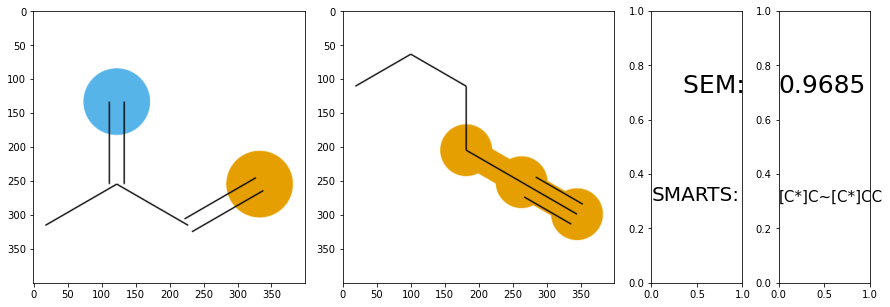

__________________________________________________________________________________________________________
mobley_1674094~mobley_8772587
./QUINTUP/30_dir_dir/finished/job_xiv/sim_18/mobley_1674094~mobley_8772587/free
./QUINTUP/30_dir_dir/finished/job_xiv/sim_20/mobley_1674094~mobley_8772587/free
./QUINTUP/30_dir_dir/finished/job_xiv/sim_17/mobley_1674094~mobley_8772587/free
./QUINTUP/30_dir_dir/finished/job_xiv/sim_19/mobley_1674094~mobley_8772587/free
./QUINTUP/30_dir_dir/finished/job_xiv/sim_16/mobley_1674094~mobley_8772587/free


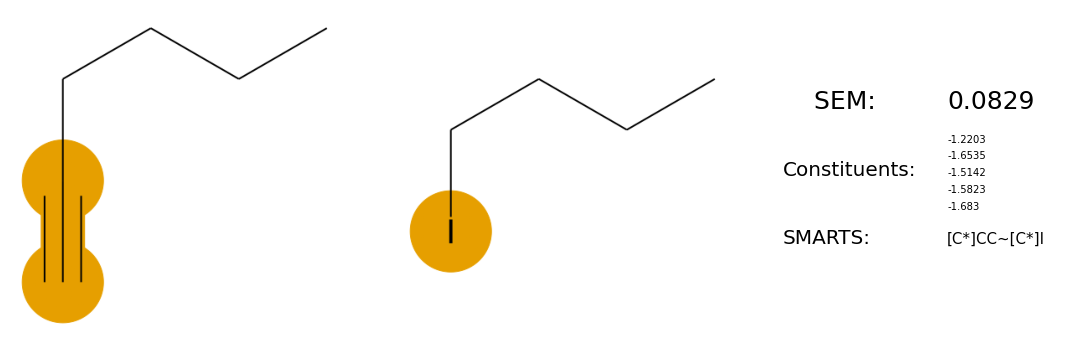

__________________________________________________________________________________________________________
mobley_36119~mobley_9617923


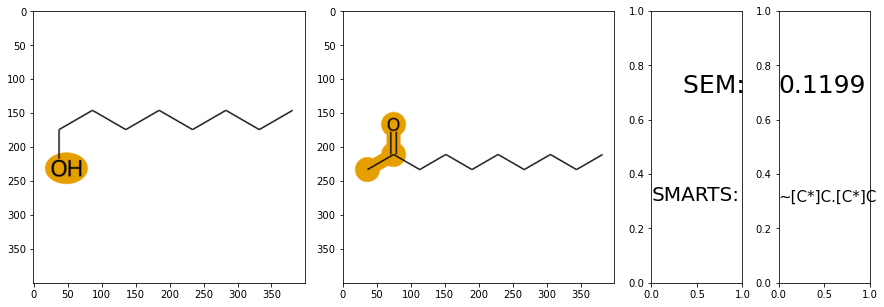

__________________________________________________________________________________________________________
mobley_9185328~mobley_1563176


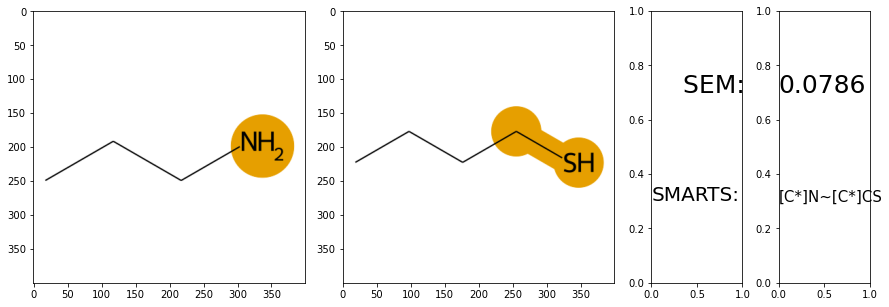

__________________________________________________________________________________________________________
mobley_1571523~mobley_2451097
./QUINTUP/30_dir_dir/finished/job_xgv/sim_7/mobley_1571523~mobley_2451097/free
./QUINTUP/30_dir_dir/finished/job_xgv/sim_9/mobley_1571523~mobley_2451097/free
./QUINTUP/30_dir_dir/finished/job_xgv/sim_8/mobley_1571523~mobley_2451097/free
./QUINTUP/30_dir_dir/finished/job_xgv/sim_6/mobley_1571523~mobley_2451097/free
./QUINTUP/30_dir_dir/finished/job_xgv/sim_10/mobley_1571523~mobley_2451097/free


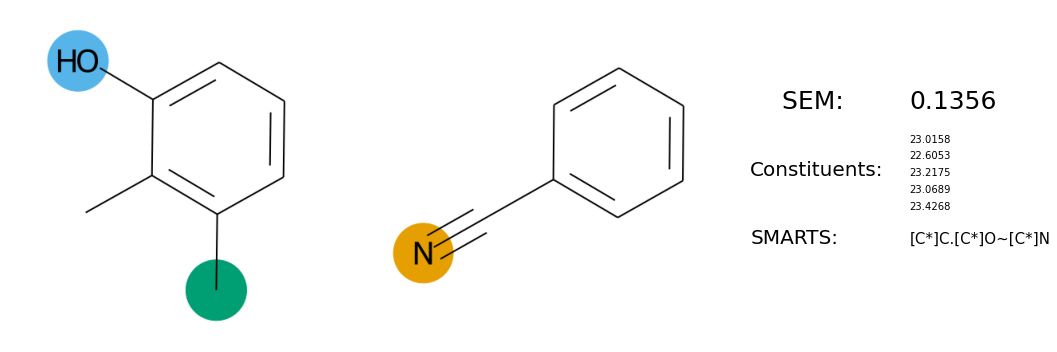

__________________________________________________________________________________________________________
mobley_1520842~mobley_4291494
./QUINTUP/29_dir_dir/finished/job_xcn/sim_3/mobley_1520842~mobley_4291494/free
./QUINTUP/29_dir_dir/finished/job_xcn/sim_1/mobley_1520842~mobley_4291494/free
./QUINTUP/29_dir_dir/finished/job_xcn/sim_5/mobley_1520842~mobley_4291494/free
./QUINTUP/29_dir_dir/finished/job_xcn/sim_4/mobley_1520842~mobley_4291494/free
./QUINTUP/29_dir_dir/finished/job_xcn/sim_2/mobley_1520842~mobley_4291494/free


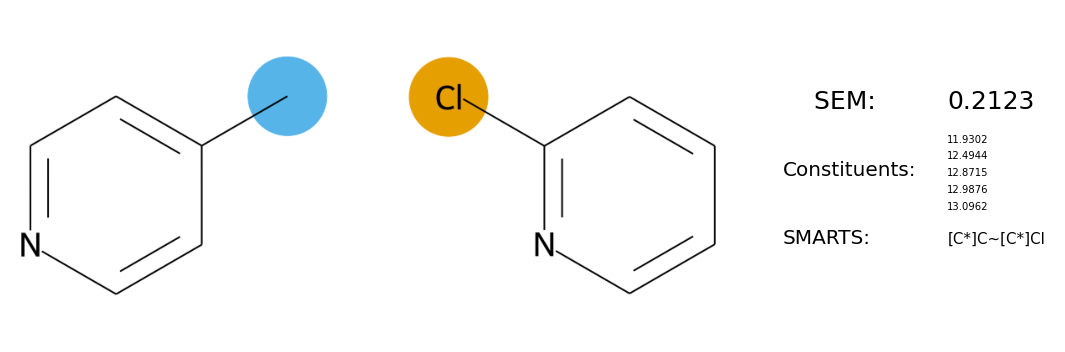

__________________________________________________________________________________________________________
mobley_1019269~mobley_1261349
./QUINTUP/30_dir_dir/finished/job_xaf/sim_14/mobley_1019269~mobley_1261349/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_13/mobley_1019269~mobley_1261349/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_12/mobley_1019269~mobley_1261349/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_15/mobley_1019269~mobley_1261349/free
./QUINTUP/30_dir_dir/finished/job_xaf/sim_11/mobley_1019269~mobley_1261349/free


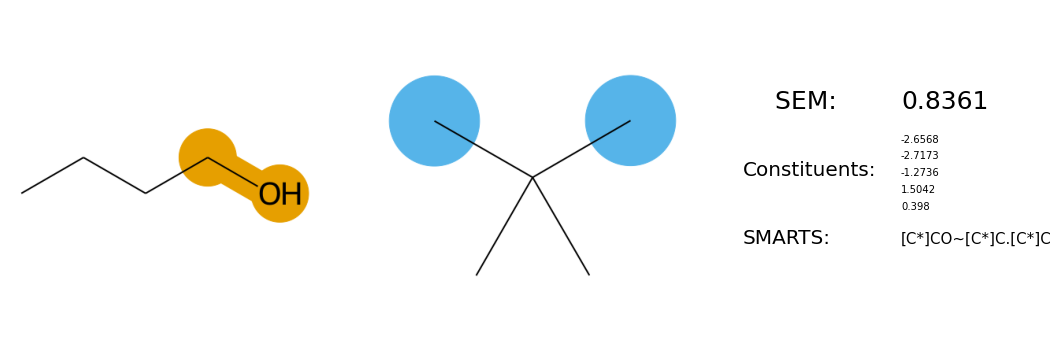

__________________________________________________________________________________________________________
mobley_1662128~mobley_5449201
./QUINTUP/29_dir_dir/finished/job_xdi/sim_14/mobley_1662128~mobley_5449201/free
./QUINTUP/29_dir_dir/finished/job_xdi/sim_13/mobley_1662128~mobley_5449201/free
./QUINTUP/29_dir_dir/finished/job_xdi/sim_12/mobley_1662128~mobley_5449201/free
./QUINTUP/29_dir_dir/finished/job_xdi/sim_15/mobley_1662128~mobley_5449201/free
./QUINTUP/29_dir_dir/finished/job_xdi/sim_11/mobley_1662128~mobley_5449201/free


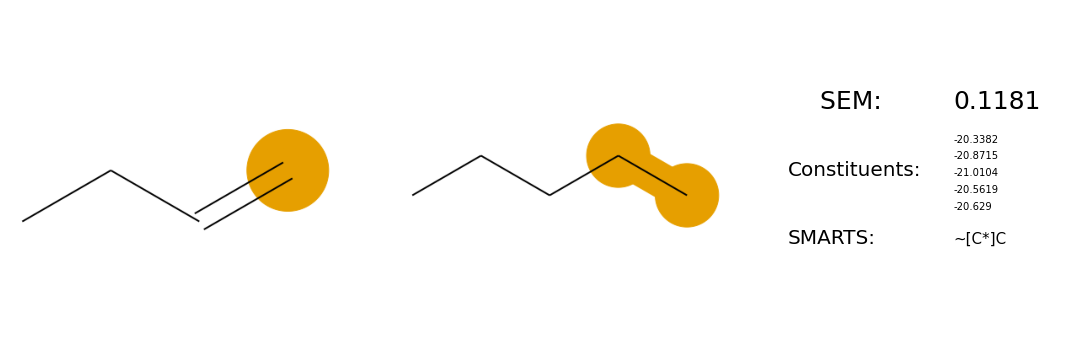

__________________________________________________________________________________________________________
mobley_1563176~mobley_1875719
./QUINTUP/30_dir_dir/finished/job_xge/sim_3/mobley_1563176~mobley_1875719/free
./QUINTUP/30_dir_dir/finished/job_xge/sim_1/mobley_1563176~mobley_1875719/free
./QUINTUP/30_dir_dir/finished/job_xge/sim_5/mobley_1563176~mobley_1875719/free
./QUINTUP/30_dir_dir/finished/job_xge/sim_4/mobley_1563176~mobley_1875719/free
./QUINTUP/30_dir_dir/finished/job_xge/sim_2/mobley_1563176~mobley_1875719/free


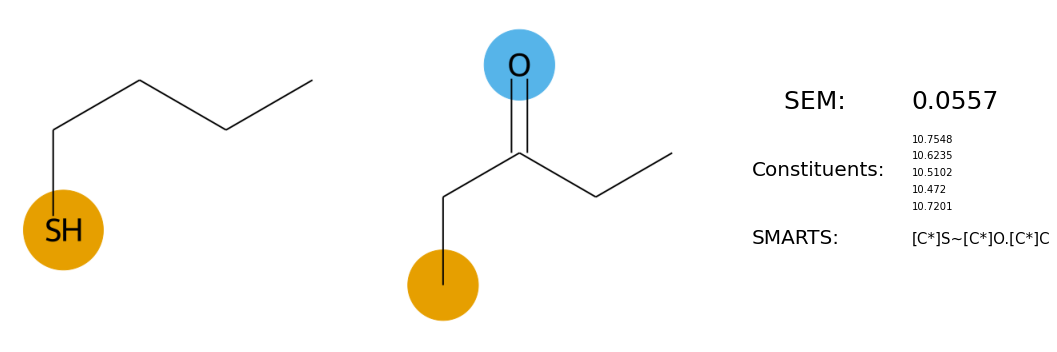

__________________________________________________________________________________________________________
mobley_7009711~mobley_9478823


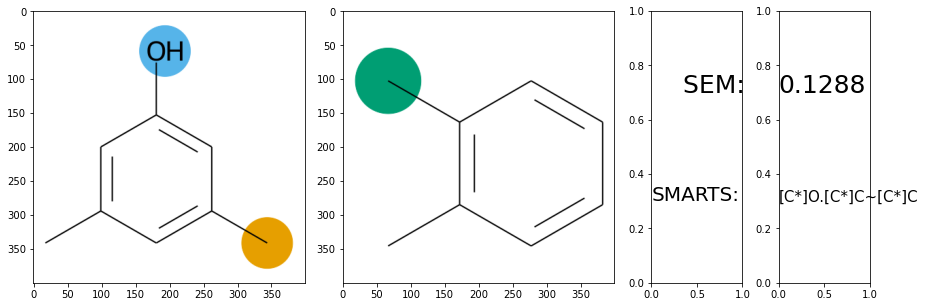

__________________________________________________________________________________________________________
mobley_1019269~mobley_5690766
./QUINTUP/30_dir_dir/finished/job_xap/sim_14/mobley_1019269~mobley_5690766/free
./QUINTUP/30_dir_dir/finished/job_xap/sim_13/mobley_1019269~mobley_5690766/free
./QUINTUP/30_dir_dir/finished/job_xap/sim_12/mobley_1019269~mobley_5690766/free
./QUINTUP/30_dir_dir/finished/job_xap/sim_15/mobley_1019269~mobley_5690766/free
./QUINTUP/30_dir_dir/finished/job_xap/sim_11/mobley_1019269~mobley_5690766/free


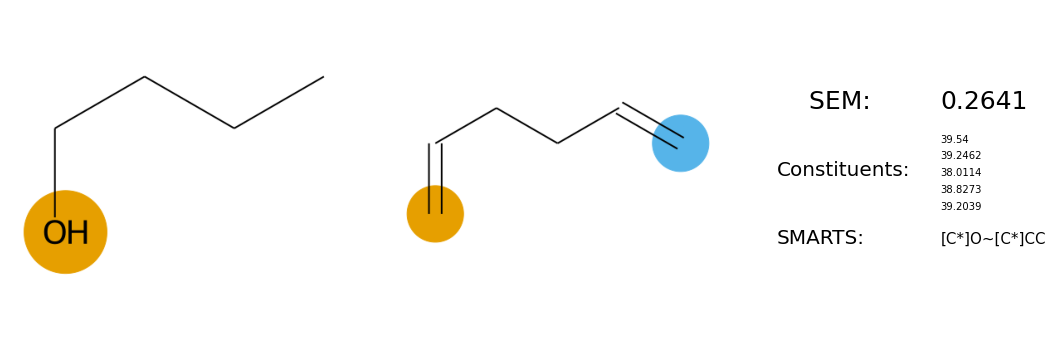

__________________________________________________________________________________________________________
mobley_1563176~mobley_6632459
./QUINTUP/30_dir_dir/finished/job_xgm/sim_3/mobley_1563176~mobley_6632459/free
./QUINTUP/30_dir_dir/finished/job_xgm/sim_1/mobley_1563176~mobley_6632459/free
./QUINTUP/30_dir_dir/finished/job_xgm/sim_5/mobley_1563176~mobley_6632459/free
./QUINTUP/30_dir_dir/finished/job_xgm/sim_4/mobley_1563176~mobley_6632459/free
./QUINTUP/30_dir_dir/finished/job_xgm/sim_2/mobley_1563176~mobley_6632459/free


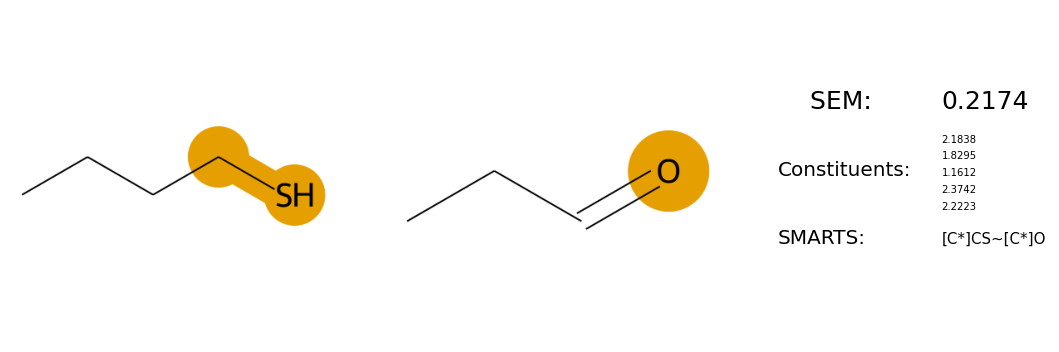

__________________________________________________________________________________________________________
mobley_1571523~mobley_1755375
./QUINTUP/29_dir_dir/finished/job_xcu/sim_18/mobley_1571523~mobley_1755375/free
./QUINTUP/29_dir_dir/finished/job_xcu/sim_20/mobley_1571523~mobley_1755375/free
./QUINTUP/29_dir_dir/finished/job_xcu/sim_17/mobley_1571523~mobley_1755375/free
./QUINTUP/29_dir_dir/finished/job_xcu/sim_19/mobley_1571523~mobley_1755375/free
./QUINTUP/29_dir_dir/finished/job_xcu/sim_16/mobley_1571523~mobley_1755375/free


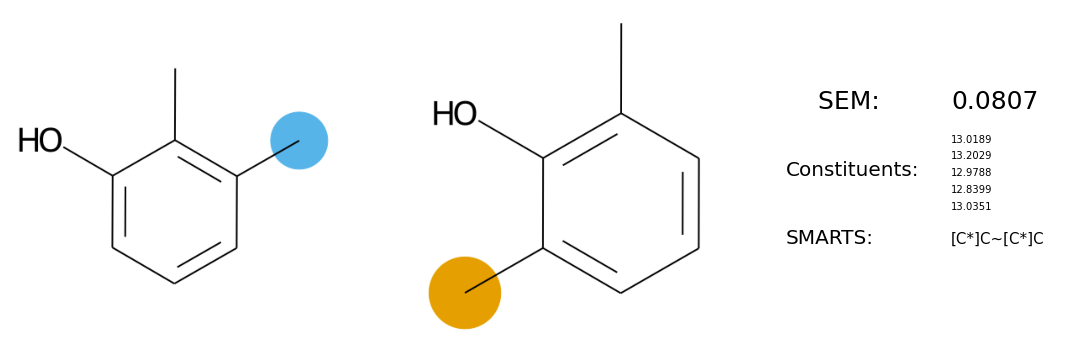

__________________________________________________________________________________________________________
mobley_9883303~mobley_5973402
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_7/mobley_9883303~mobley_5973402/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_9/mobley_9883303~mobley_5973402/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_8/mobley_9883303~mobley_5973402/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_6/mobley_9883303~mobley_5973402/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_10/mobley_9883303~mobley_5973402/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_7/mobley_9883303~mobley_5973402/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_9/mobley_9883303~mobley_5973402/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_8/mobley_9883303~mobley_5973402/free
./MGZ_

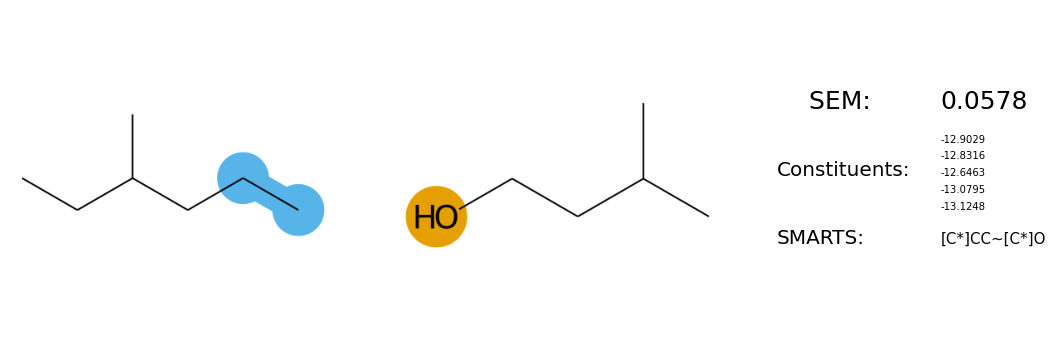

__________________________________________________________________________________________________________
mobley_2178600~mobley_9733743


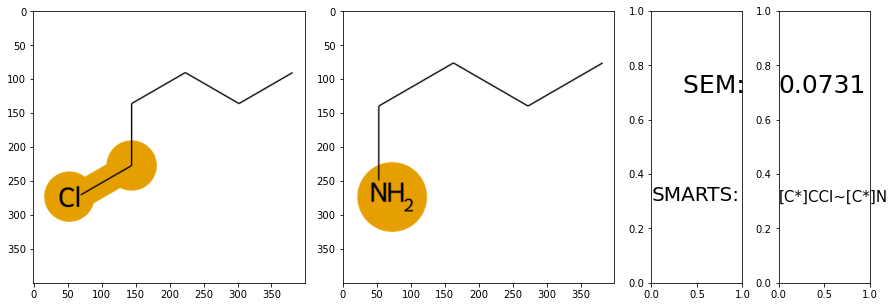

__________________________________________________________________________________________________________
mobley_1881249~mobley_1017962


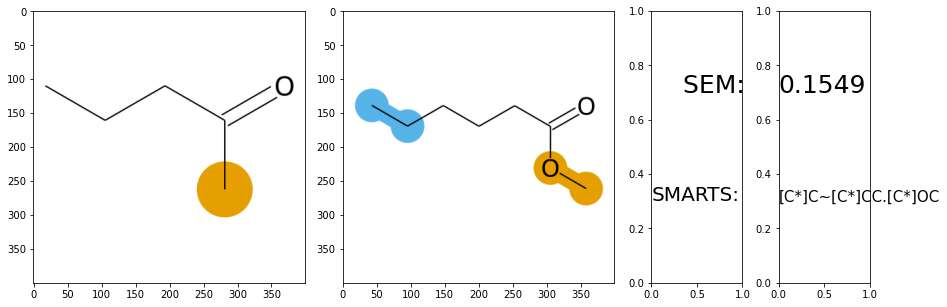

__________________________________________________________________________________________________________
mobley_9883303~mobley_7142697
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_14/mobley_9883303~mobley_7142697/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_13/mobley_9883303~mobley_7142697/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_12/mobley_9883303~mobley_7142697/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_15/mobley_9883303~mobley_7142697/free
./QUINTUP/33_dir_dir/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_11/mobley_9883303~mobley_7142697/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_14/mobley_9883303~mobley_7142697/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_13/mobley_9883303~mobley_7142697/free
./MGZ_RECENT/02_SUBSETS_quintup/round3/transform_2/job_xzeam/sim_12/mobley_9883303~mobley_7142697/free

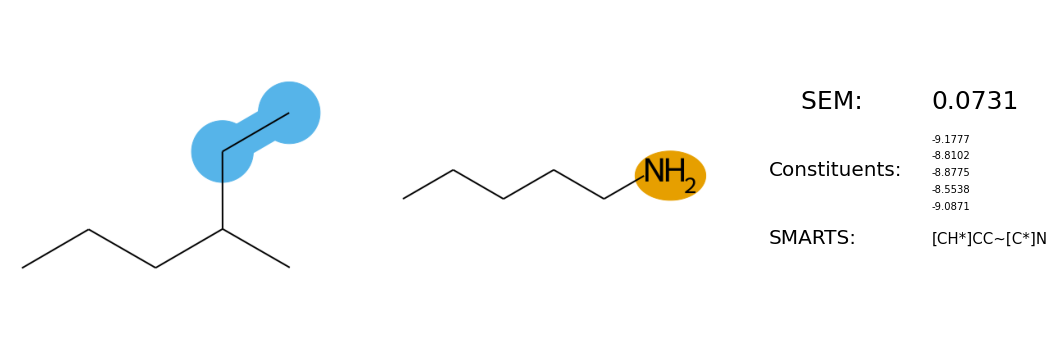

__________________________________________________________________________________________________________
mobley_2310185~mobley_1650157


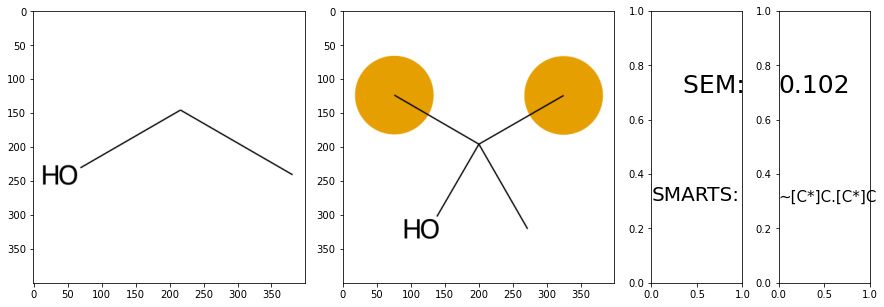

__________________________________________________________________________________________________________
mobley_7943327~mobley_1019269


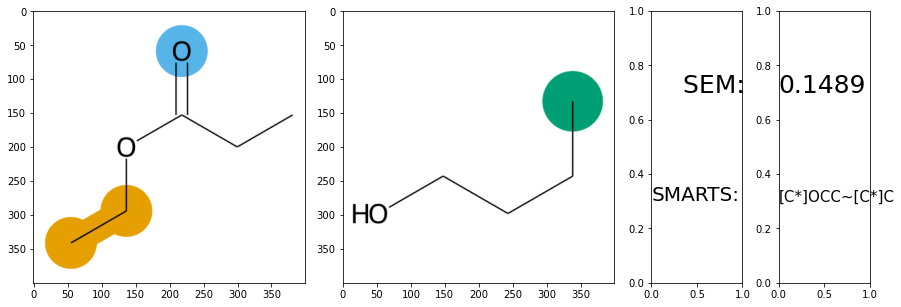

__________________________________________________________________________________________________________
mobley_2143011~mobley_1674094


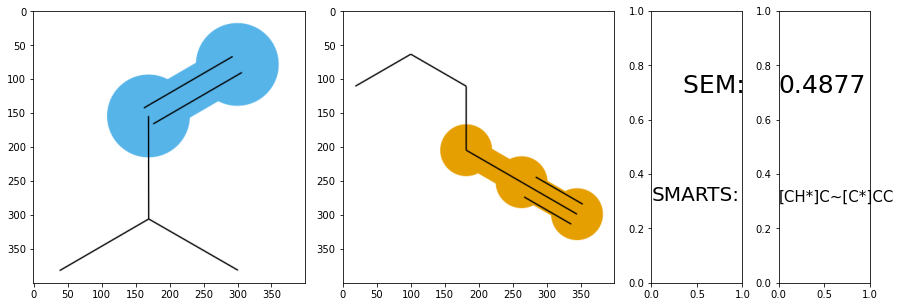

__________________________________________________________________________________________________________
mobley_1674094~mobley_252413
./QUINTUP/30_dir_dir/finished/job_xin/sim_3/mobley_1674094~mobley_252413/free
./QUINTUP/30_dir_dir/finished/job_xin/sim_1/mobley_1674094~mobley_252413/free
./QUINTUP/30_dir_dir/finished/job_xin/sim_5/mobley_1674094~mobley_252413/free
./QUINTUP/30_dir_dir/finished/job_xin/sim_4/mobley_1674094~mobley_252413/free
./QUINTUP/30_dir_dir/finished/job_xin/sim_2/mobley_1674094~mobley_252413/free


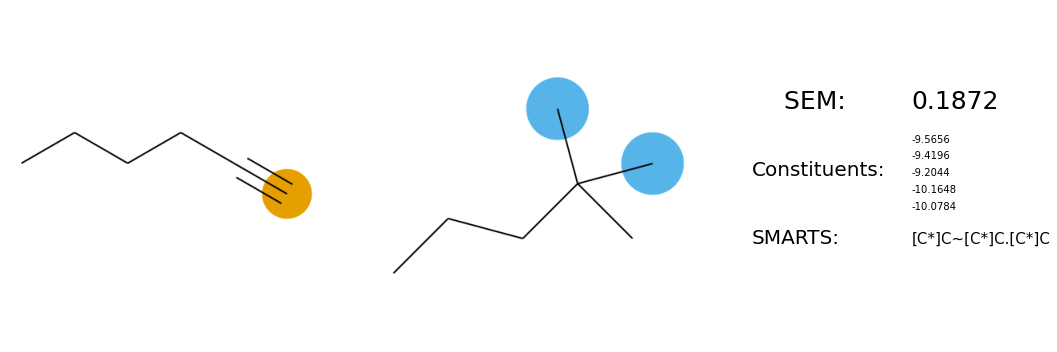

__________________________________________________________________________________________________________


In [8]:
plot_perts(quints_infos[(quints_infos["sem"] > 0.001)].sample(50))